# Time series analysis techniques

This notebook explores the various techniques for analyzing time series.

## Setup

In [1]:
import pandas as ps
import numpy as np
import keras
from pandas.tools.plotting import scatter_matrix
import pyflux
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

Using Theano backend.
/Users/willem/dev/ml/keras/mlpy/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
print "pandas %s" % (ps.__version__)
print "numpy %s" % (np.__version__)
print "keras %s" % (keras.__version__)
print "matplotlib %s" % (plt.__version__)

pandas 0.19.0
numpy 1.11.2
keras 1.1.1
matplotlib 1.11.2


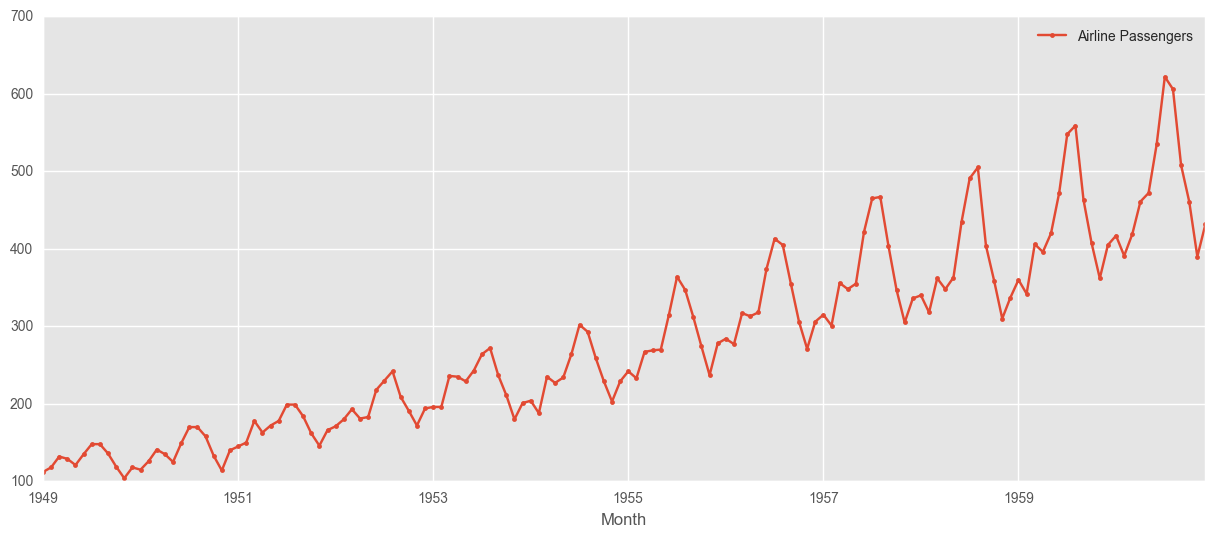

In [2]:
ap = ps.read_excel('international-airline-passengers.xls', skiprows=14)
ap.columns = [["Month", "Passengers"]]
apts = ps.Series(ap.Passengers.values.astype('float'), index=ap.Month)
ax = apts.plot(marker='.', label='Airline Passengers')
ax.legend()

## Plotting trends

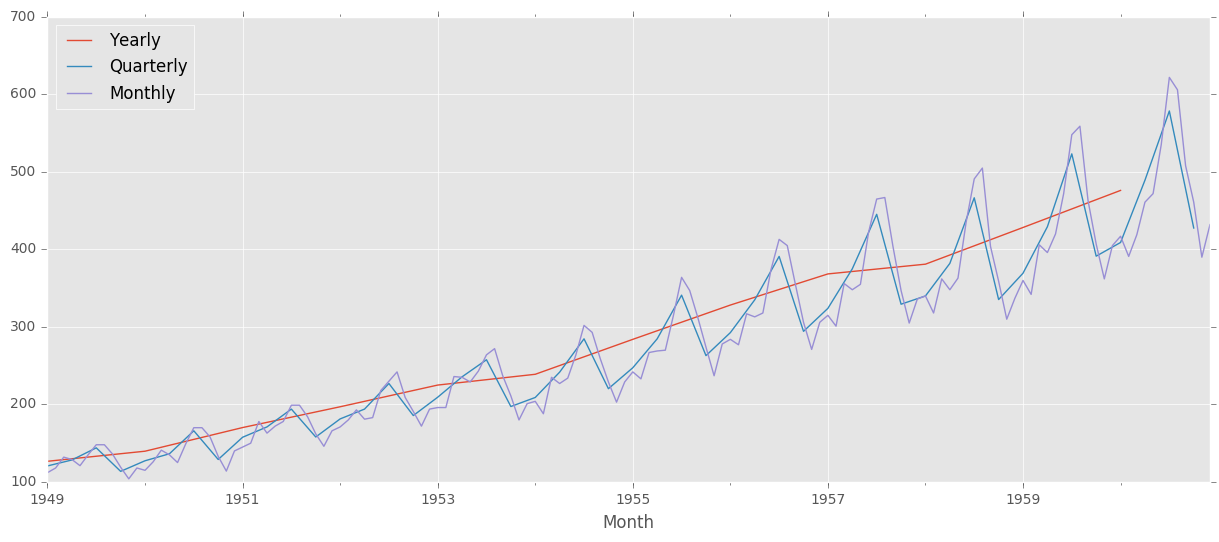

In [208]:
#let's look at the various trends
yearly = apts.resample('A').mean()
quarterly = apts.resample('Q').mean()
monthly = apts.resample('M').mean()
yearly.plot(label='Yearly')
quarterly.plot(label='Quarterly')
ax = monthly.plot(label='Monthly')
ax.legend(loc='best')

## Exploratory analysis

In [127]:
#Check some properties
apts.autocorr()

0.96019464804985255

This series is obviously highly autocorrelating. For additional theoretical information:
https://en.wikipedia.org/wiki/Autocorrelation

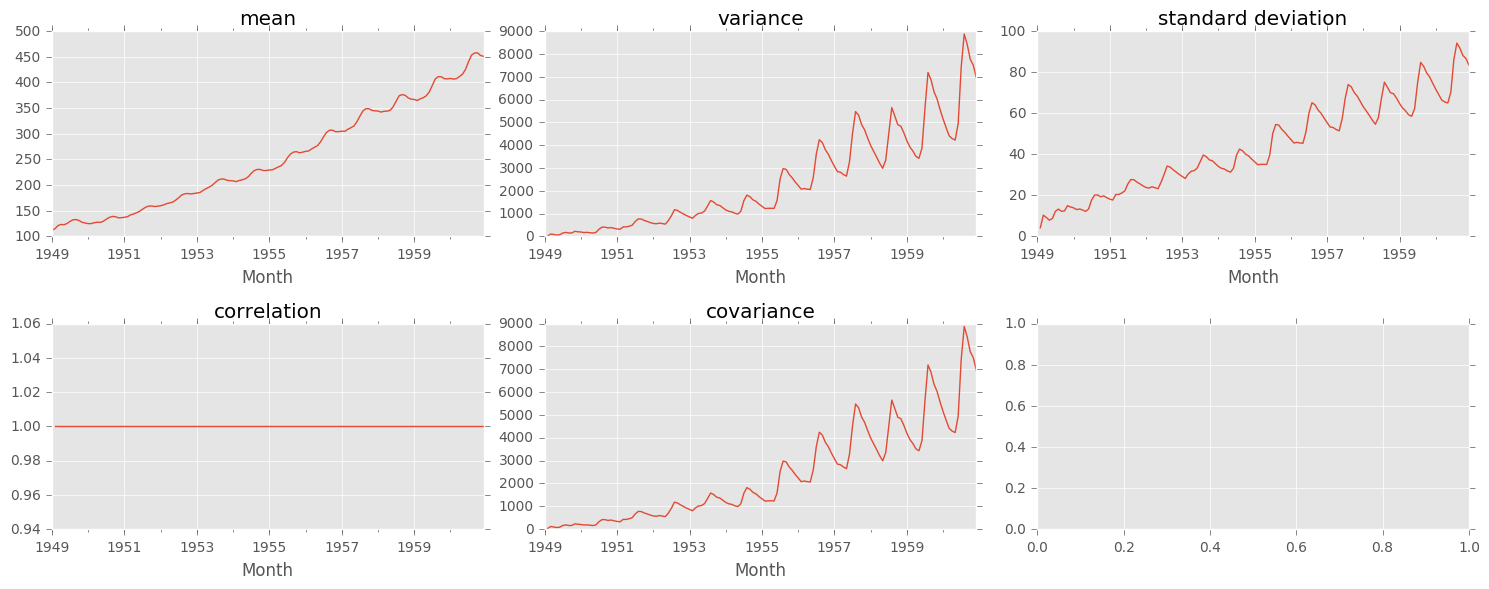

In [142]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6));

#exponential weighted function analysis
span_value = 25
apts.ewm(span=span_value).mean().plot(title = 'mean', ax = axes[0][0])
apts.ewm(span=span_value).var().plot(title='variance', ax = axes[0][1])
apts.ewm(span=span_value).std().plot(title='standard deviation', ax = axes[0][2])
apts.ewm(span=span_value).corr().plot(title='correlation', ax = axes[1][0])
apts.ewm(span=span_value).cov().plot(title='covariance', ax = axes[1][1])
plt.tight_layout()

EWM is used to provide functions over exponentially expanding windows

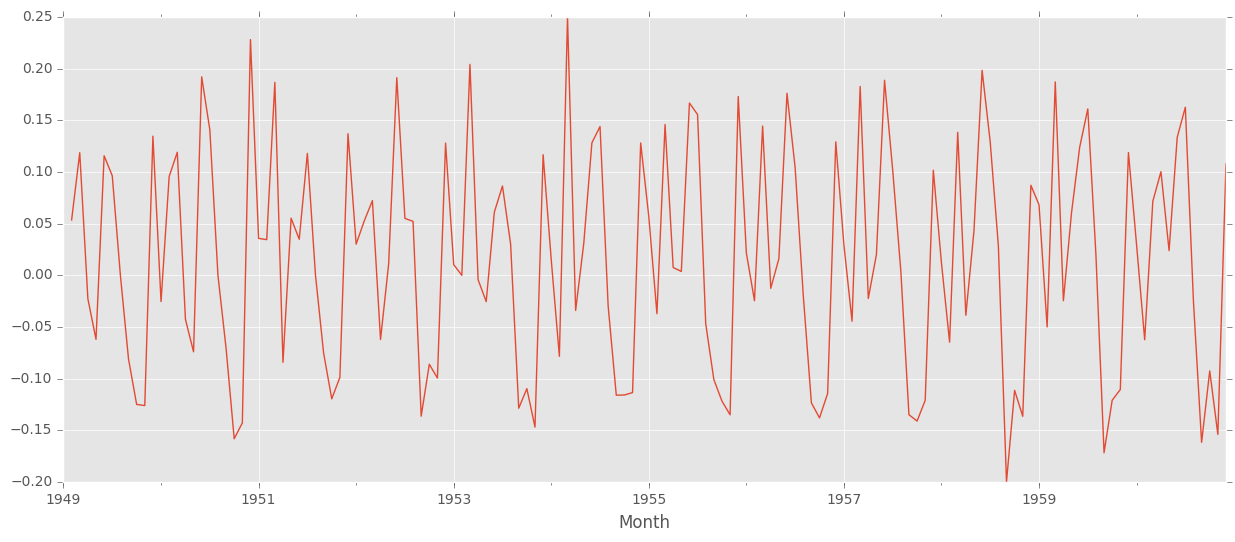

In [170]:
#show % change per timestep
apts.pct_change().plot()

In [172]:
#measure peak-to-peak or amplitude
apts['1950':'1955'].ptp()

250

In [177]:
#get Nth quantile (Benchmarking)
apts.quantile(.01)

112.86

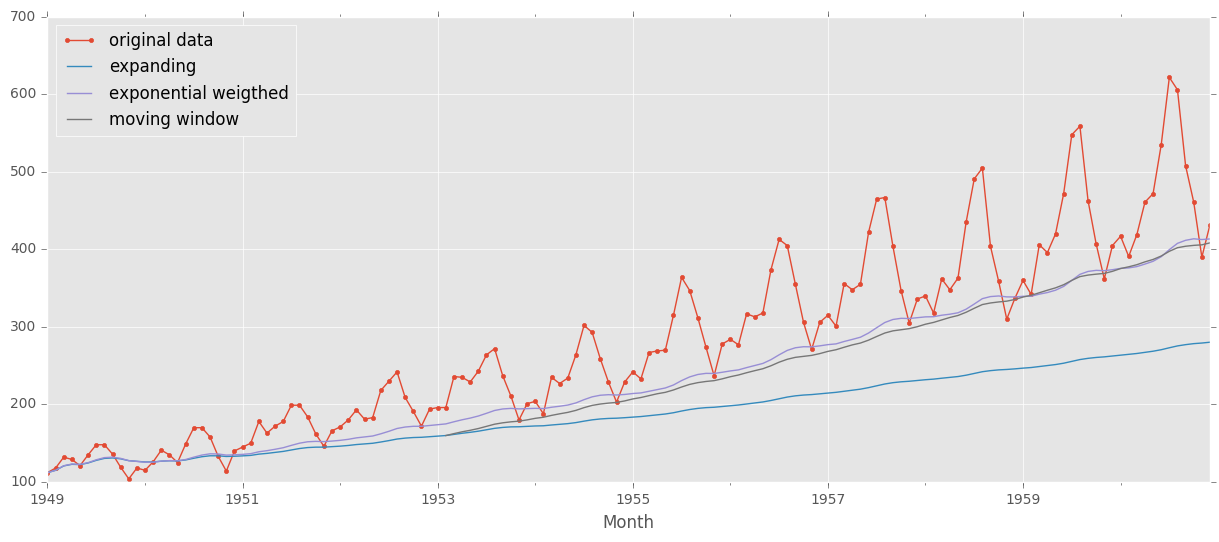

In [231]:
#comparing EWM mean with fixed moving window mean and expanding window mean
apts.plot(marker='.', label='original data')
apts.expanding().mean().plot(label='expanding')
apts.ewm(span=50).mean().plot(label='exponential weigthed')
apts.rolling(50).mean().plot(label='moving window')
plt.legend(loc='best')

## Test for stationary time series using the Dickey-Fuller test

Let's test the time series for the stationary property using the Dickey-Fuller test.
*  If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary

In [225]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = ps.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print dfoutput

In [226]:
test_stationary(apts)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


Ergo, our timeseries is not stationary

## Testing for White Noise using the Ljung-Box test and Box-Pierce test

The Ljung–Box test may be defined as:

$H_0$: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).<br>
$H_a$: The data are not independently distributed; they exhibit serial correlation.

$Q = n(n+2)\sum_{k=1}^{h}\frac{\rho_k^2}{n-k}$

Where:<br>
- $n$: sample size
- $\rho_k$: autocorrelation at lag $k$
- $h$: number of lags

$Q$ follows the $\chi_{(h)}^2$ distribution.

The test statistic for rejection of $H_0$ is:<br>
$Q > \chi_{1-a,h}^2$ <br>
where: <br>
$\chi_{1-a,h}^2$ is the $a$th quantile of the distribution with $h$ degrees of freedom

In [15]:
from statsmodels.sandbox.stats.diagnostic import *

degrees_of_freedom = 5
ljung_result = acorr_ljungbox(apts, lags = 5, boxpierce = True)

In [42]:
from scipy.stats import chi2
dfljung = ps.DataFrame(np.asmatrix(ljung_result).transpose(), columns=['Test statistic','p value', 'Test statistic Box-Pierce', 'p value Box-Pierce'])
dfs = np.arange(1,6,1)
q99chi = []
for df in dfs:
    q99chi.append(chi2.pdf(.99,df))
q95chi = []
for df in dfs:
    q95chi.append(chi2.pdf(.95,df))

dfljung['99th quantile chi2'] = q99chi
dfljung['95th quantile chi2'] = q95chi
dfljung

,Test statistic,p value,Test statistic Box-Pierce,p value Box-Pierce,99th quantile chi2,95th quantile chi2
0,132.141539,1.393231e-30,129.426301,5.471060e-30,0.244409,0.254541
1,245.646160,4.556318e-54,239.821208,8.384679e-53,0.304785,0.310943
2,342.674826,5.751088e-74,333.526974,5.499710e-72,0.241965,0.241814
3,427.738684,2.817731e-91,415.095056,1.522155e-88,0.150869,0.147698
4,504.796570,7.360195e-107,488.458387,2.473624e-103,0.079848,0.076575


Ergo we conclude that for all lags the time series is **not** independently varying (i.e. white noise)

## Fourier analysis of a time series

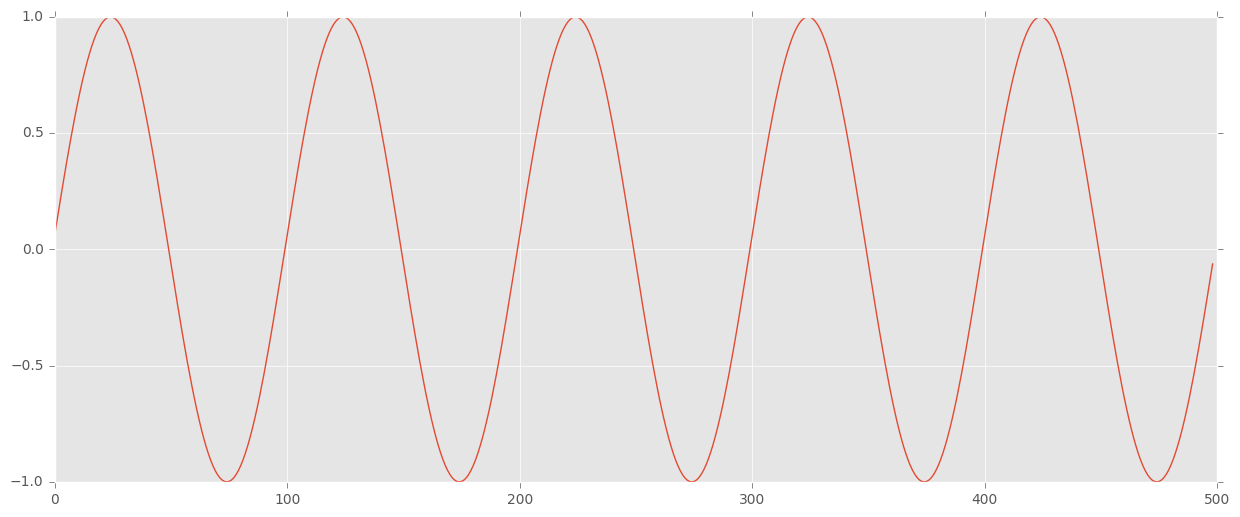

In [87]:
#from scipy.fftpack import *
from numpy import fft

#setup a sinewave with f = 5
tmpdata = ps.Series(1, index=np.arange(1,500))
arg = (tmpdata.index * np.pi)/50

tmpdata = np.sin((tmpdata.index * np.pi)/50) 

plt.plot(tmpdata)
#plt.plot(arg)

Above shows a sine series with five cycles, ergo f=5

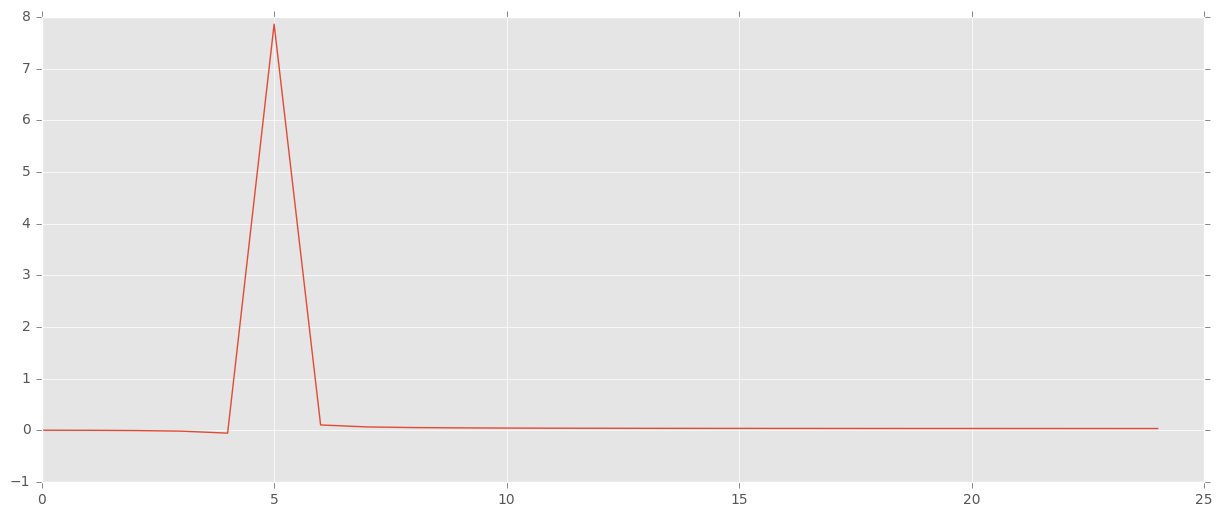

In [92]:
plt.plot(np.fft.fft(tmpdata)[0:25])

A simple call to np.fft.fft() shows that this series consists of one frequency, 5, suprise!

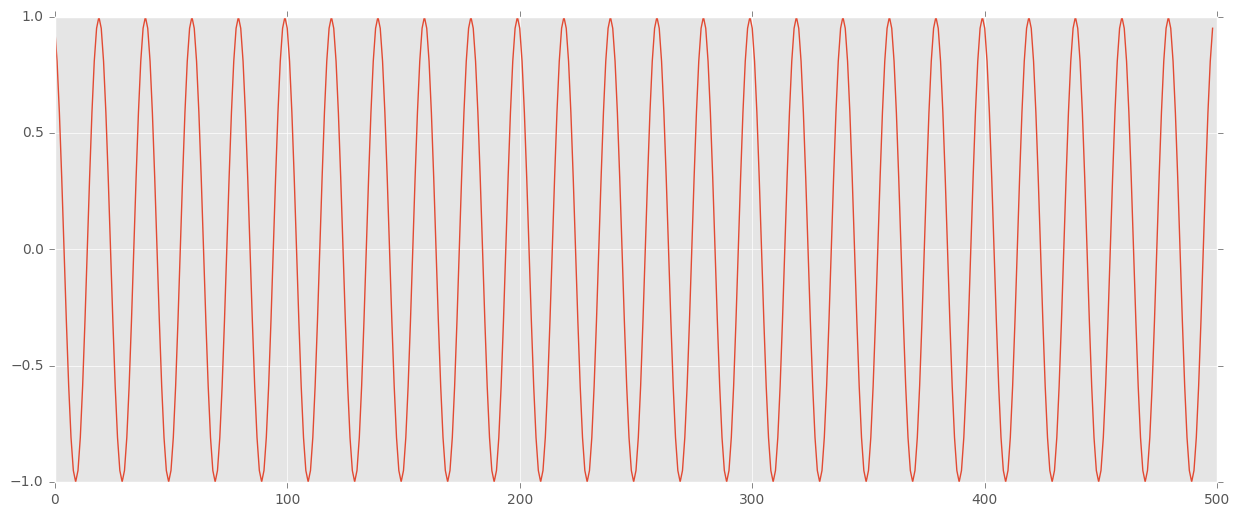

In [97]:
#Create signal with f=25
tmpdata2 = ps.Series(1, index=np.arange(1,500))
tmpdata2 = np.cos((tmpdata2.index * np.pi)/10) 
plt.plot(tmpdata2)

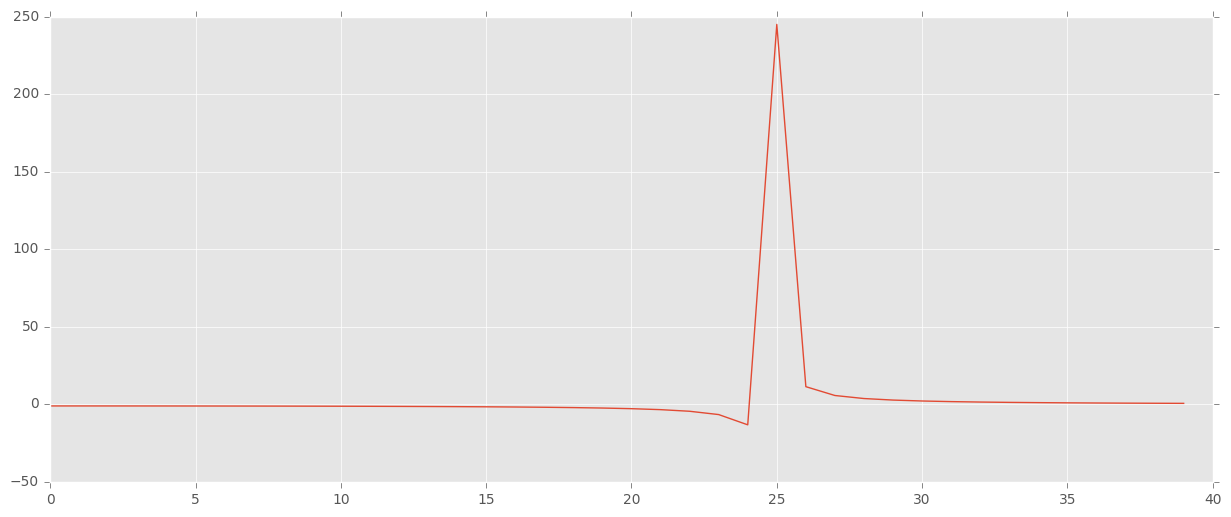

In [100]:
plt.plot(np.fft.fft(tmpdata2)[0:40])

Indeed, f=25. Note that it doesn't matter that we used the cos() function to generate the series!

Now let's combine the two series

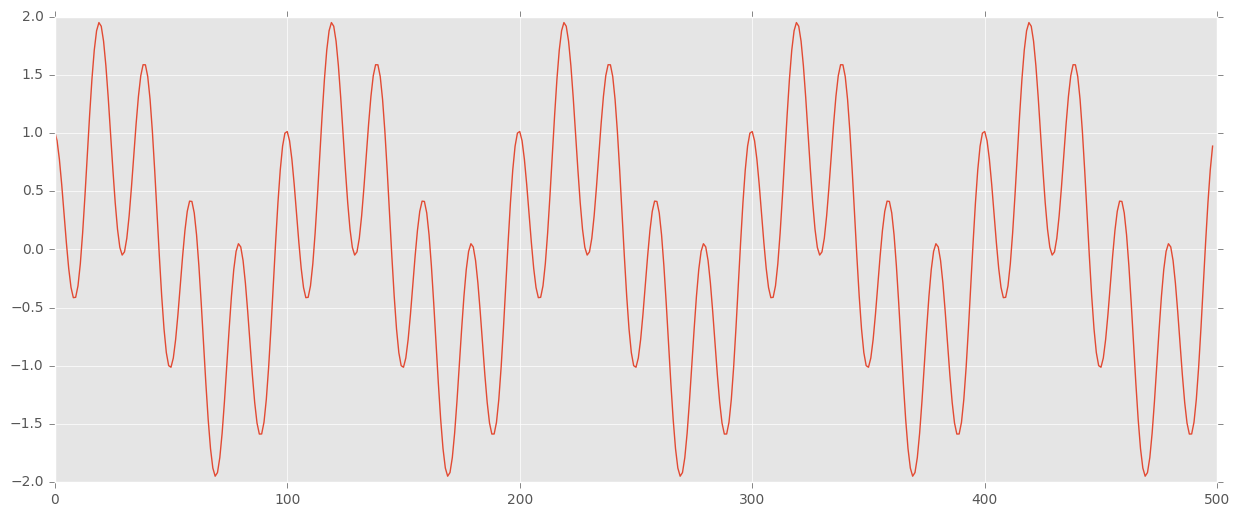

In [101]:
tmpdata3 = tmpdata + tmpdata2
plt.plot(tmpdata3)

Now let's have a look at the FFT

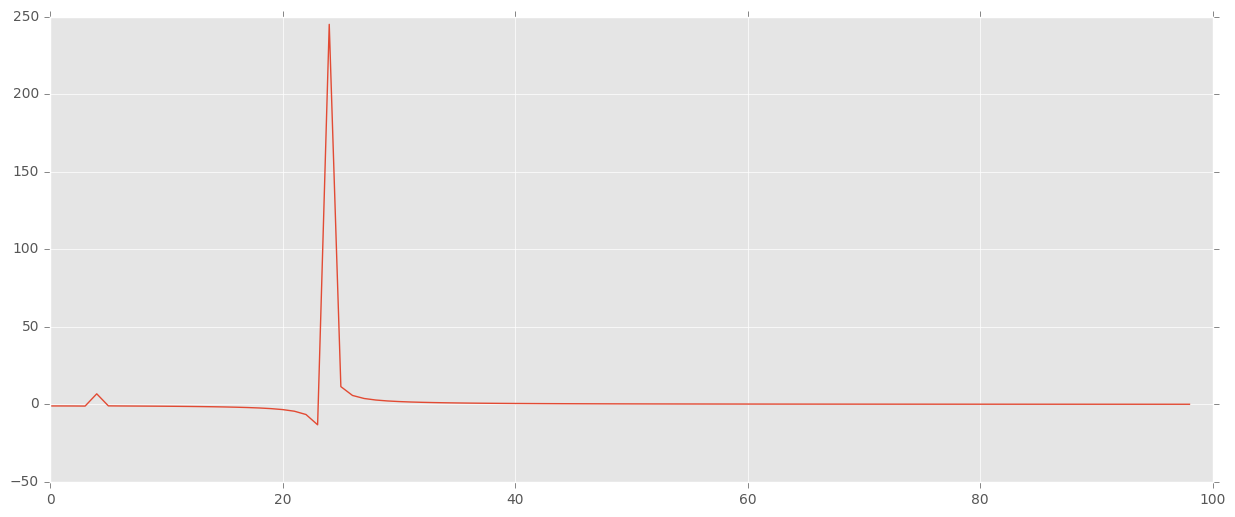

In [104]:
plt.plot(np.fft.fft(tmpdata3)[1:100])

We can now see that our signal consists of two frequencies. f=5 and f=25. The FFT returns a lower value for f=5 because the five periods contribute less that 25 periods.

Now let's have look at our airline data: Having 12 years of airline data with strong seasonality we expect at least a FFT response on f=12

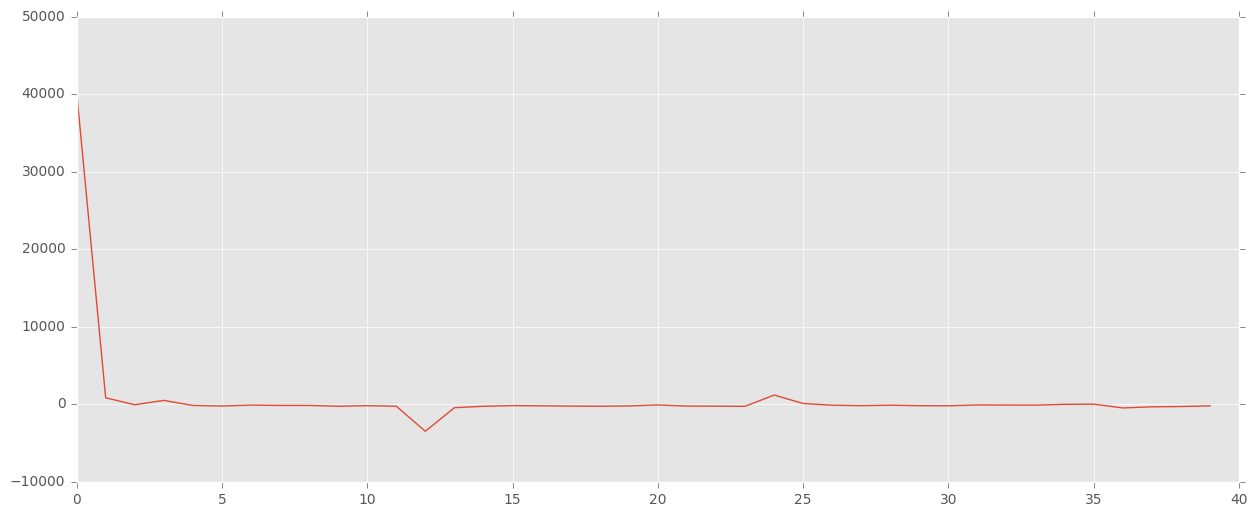

In [108]:
plt.plot(np.fft.fft(apts)[0:40])

Indeed we see a response on f=12. We also see the cycle each half year on f=24. The big peak on f=0 is simply the magnitude of the total series because we applied the FFT on a non-stationary series.

Based on the analysis result we can now try to reconstruct the series from the fouries base functions we found in our analysis. We can then use this to extend or forecast the series!

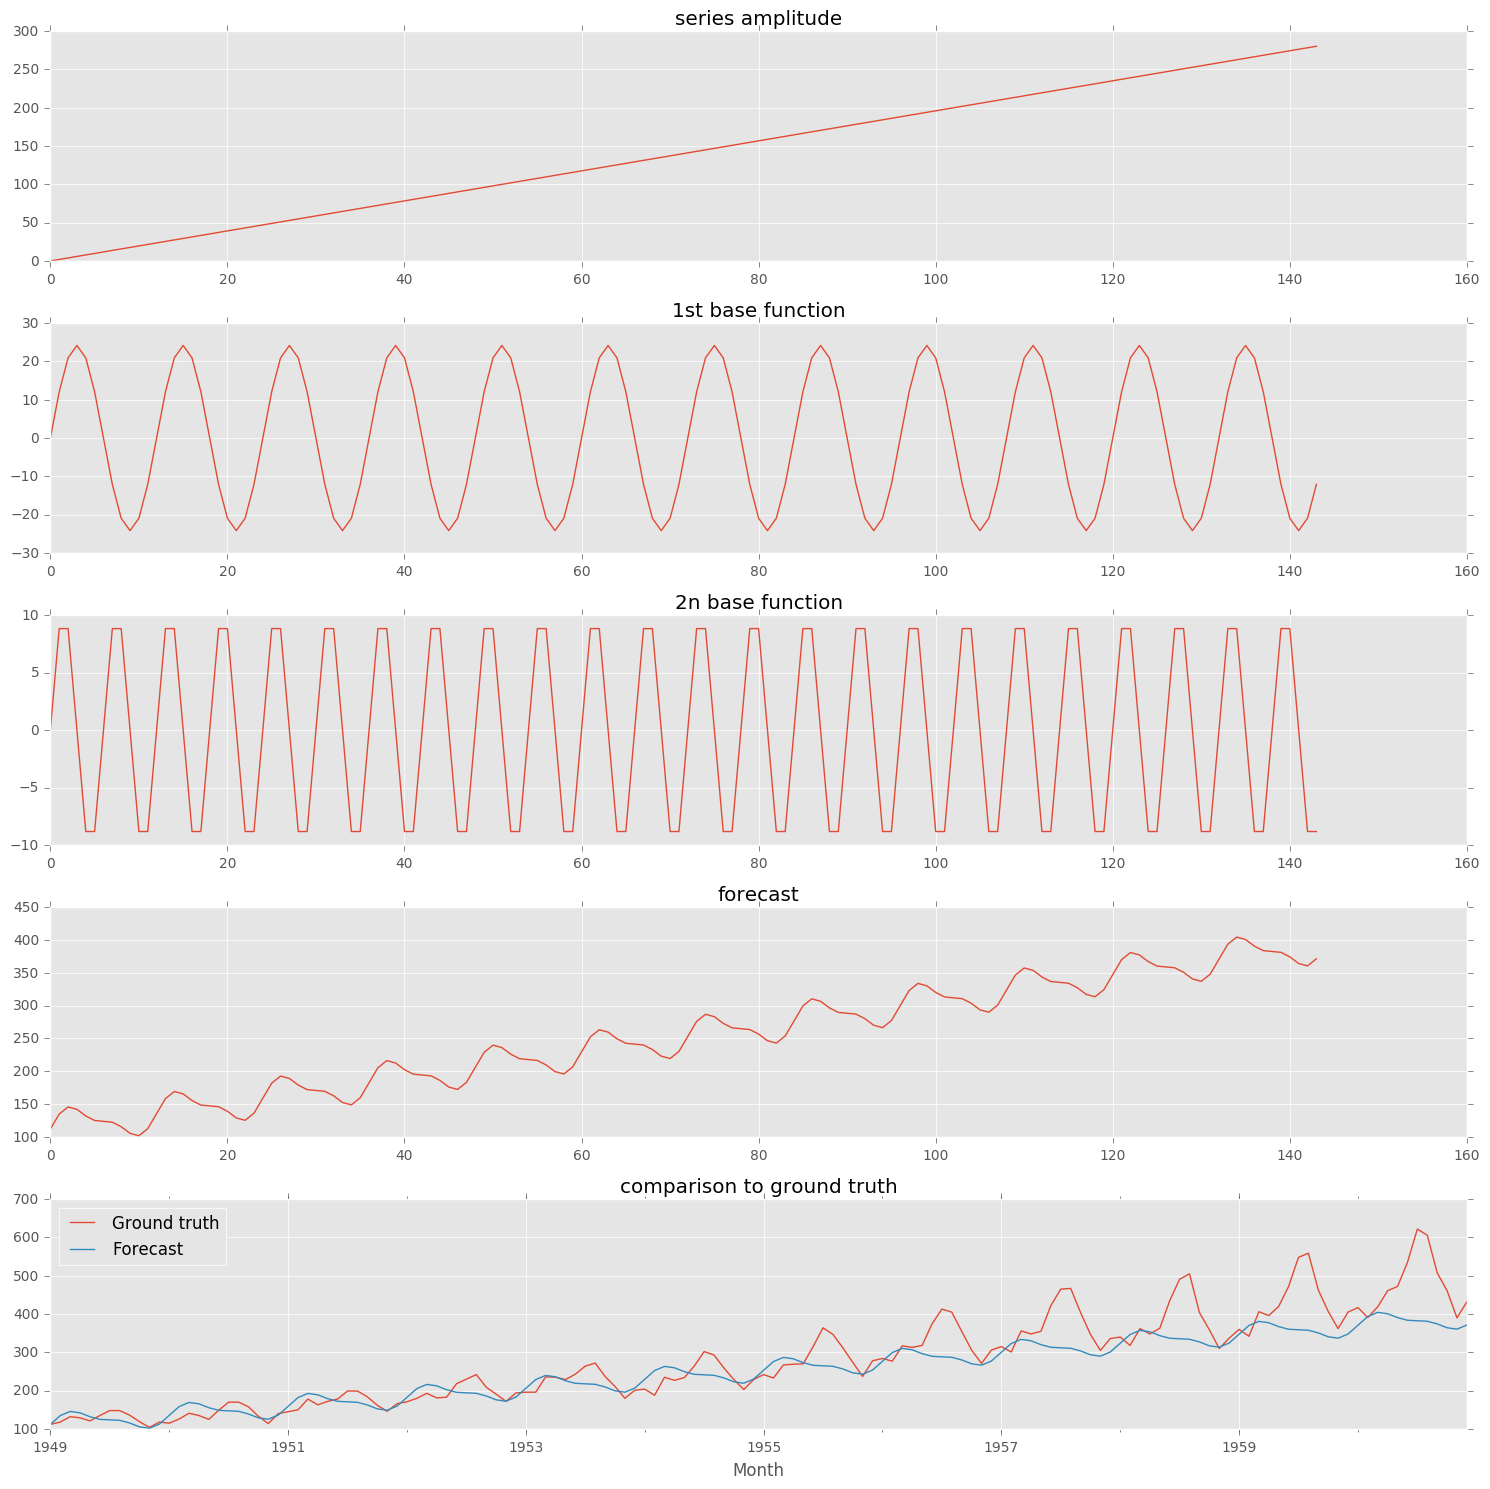

In [173]:
forecast = ps.Series(1, index=np.arange(0,len(apts)))
base12 = np.sin((forecast.index * np.pi * 2) / (len(apts)/12)) *  (np.abs(np.fft.fft(apts)[12]) / len(apts))#1st base function was at f=12
base24 = np.sin((forecast.index * np.pi * 2) / (len(apts)/24)) * (np.abs(np.fft.fft(apts)[24]) / len(apts)) #2nd base function was at f=24
f0_amplitude = np.max(np.fft.fft(apts)[0:40]) / len(apts) # f=0 was about 40000 which we divide by the contributions or N(apts) = 144
base0 = np.linspace(0,f0_amplitude, len(apts), dtype=float)

plt.figure(figsize=(15,15))
ax = plt.subplot(511)
ax.set_title("series amplitude")
plt.plot(base0)
ax = plt.subplot(512)
ax.set_title("1st base function")
plt.plot(base12)
ax = plt.subplot(513)
ax.set_title("2n base function")
plt.plot(base24)
ax = plt.subplot(514)
ax.set_title("forecast")
plt.plot(base0 + base12 + base24 + apts[0])
ax = plt.subplot(515)
ax.set_title("comparison to ground truth")
tmpdf = ps.DataFrame()
tmpdf['Ground truth'] = apts
tmpdf['Forecast'] = base0 + base12 + base24 + apts[0]
tmpdf.plot(ax=ax)
plt.tight_layout()

Comparing the original data with our forecast we can see the we are missing the increasing variation (i.e. heteroscedasticity) that is present in the original data. The non-stationary character of our base function is causing this error in our forecast. FFT assumes a stationary time series.

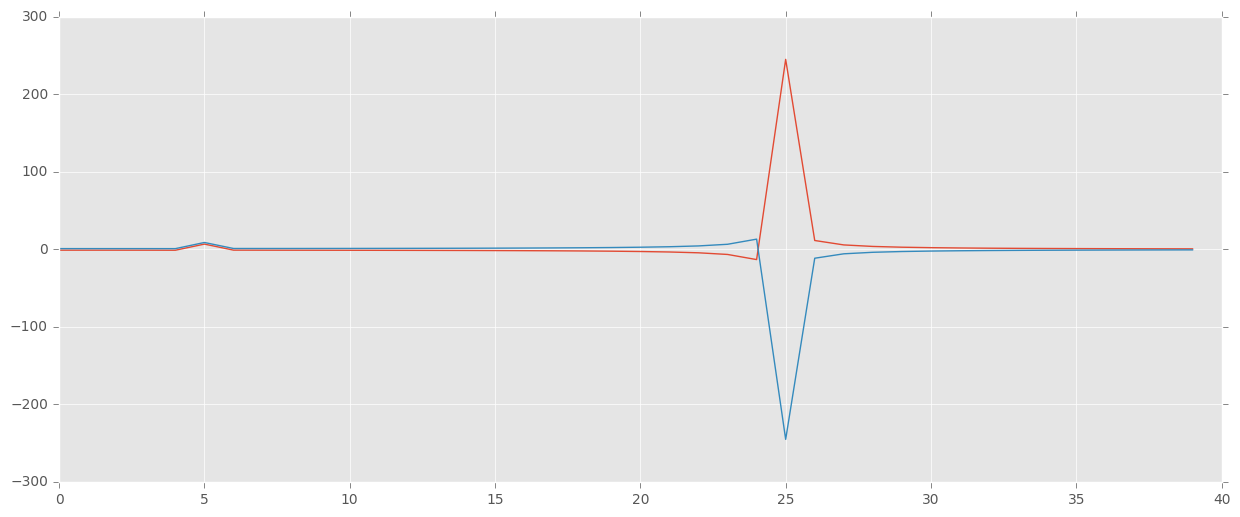

In [111]:
multidimensional_series = ps.DataFrame()
multidimensional_series['dim1'] = tmpdata
multidimensional_series['dim2'] = tmpdata2
plt.plot(np.fft.fft2(multidimensional_series)[0:40])

Above we see an alternative way of calculating the FFT for a 2-dimensional dataset. np.fft supports N-dimensional data with np.fft.fftn()

Some additional reading: <br>
have a look at: https://gist.github.com/tartakynov/83f3cd8f44208a1856ce <br>
and here : https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/ <br>
and a nice succinct example here: http://glowingpython.blogspot.nl/2011/08/how-to-plot-frequency-spectrum-with.html

## Determining a local stationary wavelet function of the time series

## Removing Trends / Detrending

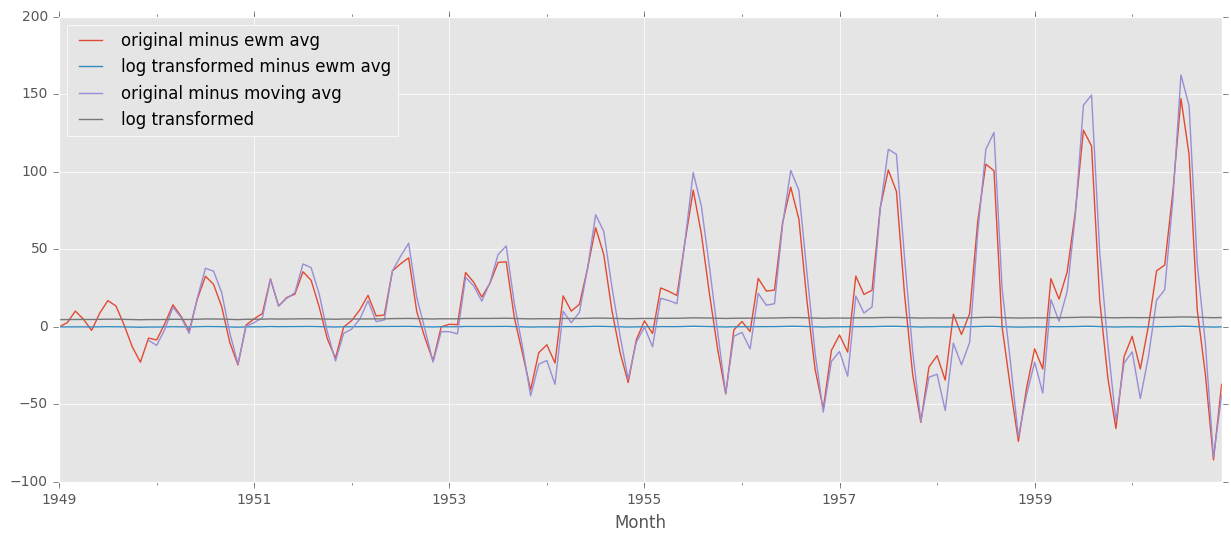

In [236]:
apts_log = np.log(apts)
apts_min_mavg = apts - apts.rolling(12).mean()
apts_min_ewm_avg = apts - apts.ewm(span=12).mean()
apts_log_min_ewm_avg = apts_log - apts_log.ewm(halflife=12).mean()
apts_min_ewm_avg.plot(label='original minus ewm avg')
apts_log_min_ewm_avg.plot(label='log transformed minus ewm avg')
apts_min_mavg.plot(label='original minus moving avg')
#apts.plot(label='original')
apts_log.plot(label='log transformed')
plt.legend(loc='best')

In [227]:
test_stationary(apts_log)

Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [229]:
test_stationary(apts_min_mavg.dropna())

Test Statistic                  -3.164968
p-value                          0.022104
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [237]:
test_stationary(apts_log_min_ewm_avg)

Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


A means of reducing seasonality is differencing. E.g.

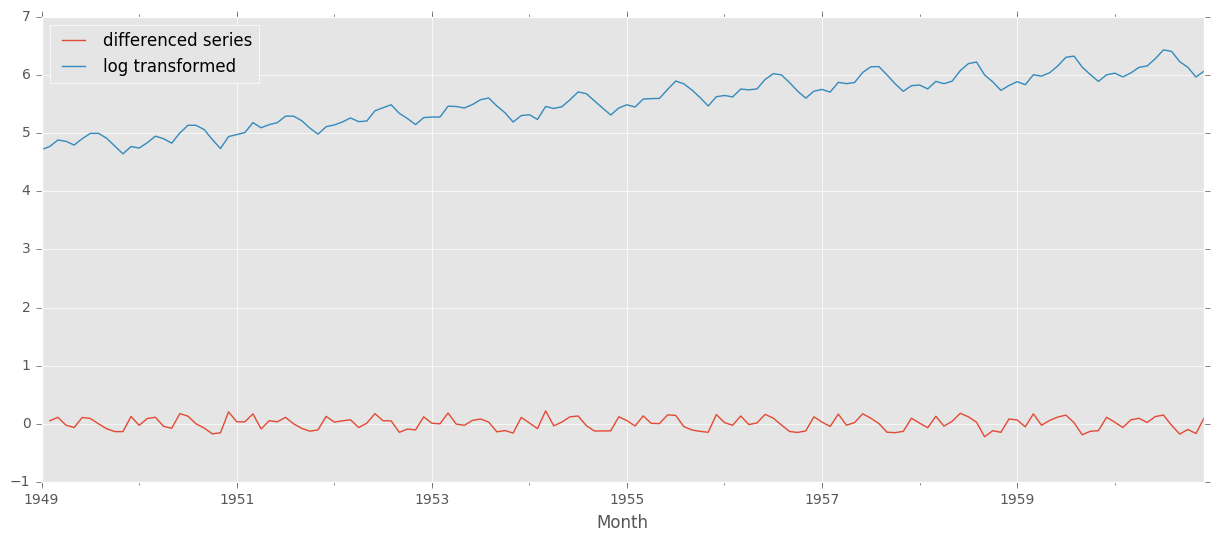

In [240]:
(apts_log - apts_log.shift()).plot(label='differenced series')
apts_log.plot(label='log transformed')
plt.legend(loc='best')

## Decomposition of a time series

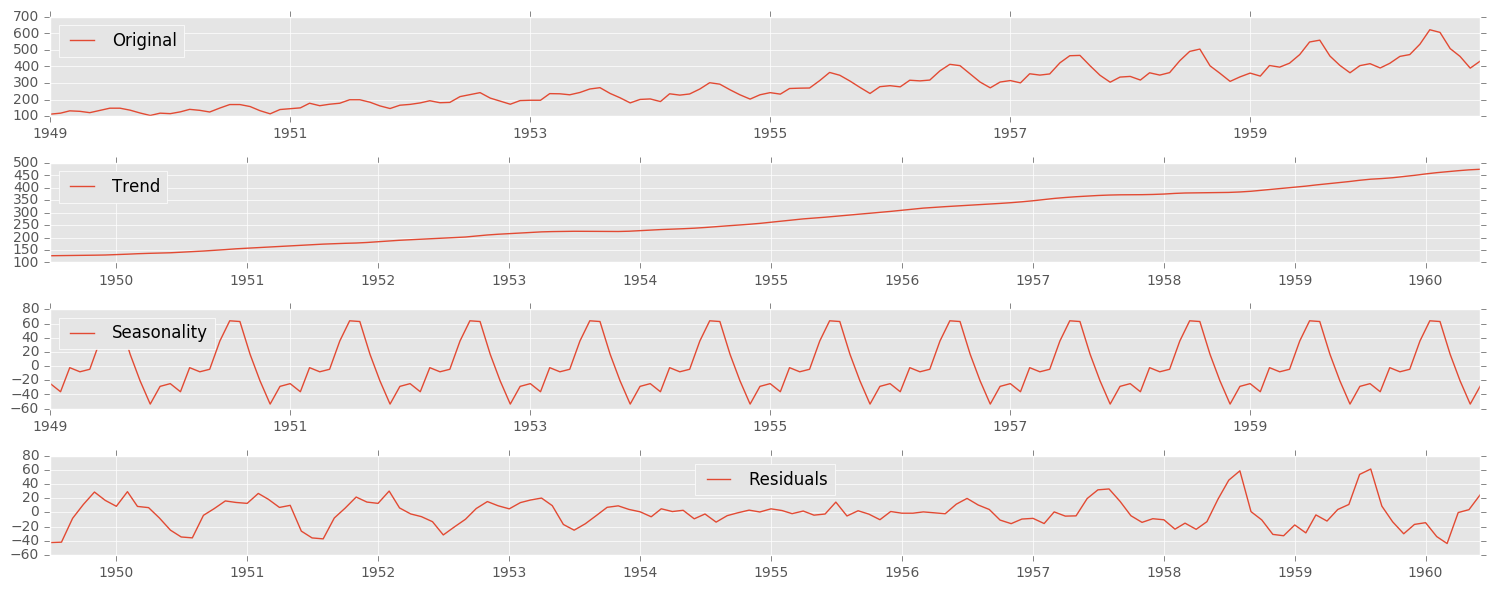

In [244]:
from statsmodels.tsa.seasonal import seasonal_decompose
dec_ts = apts
decomposition = seasonal_decompose(dec_ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(dec_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Autocorrelation and Partial Autocorrelation

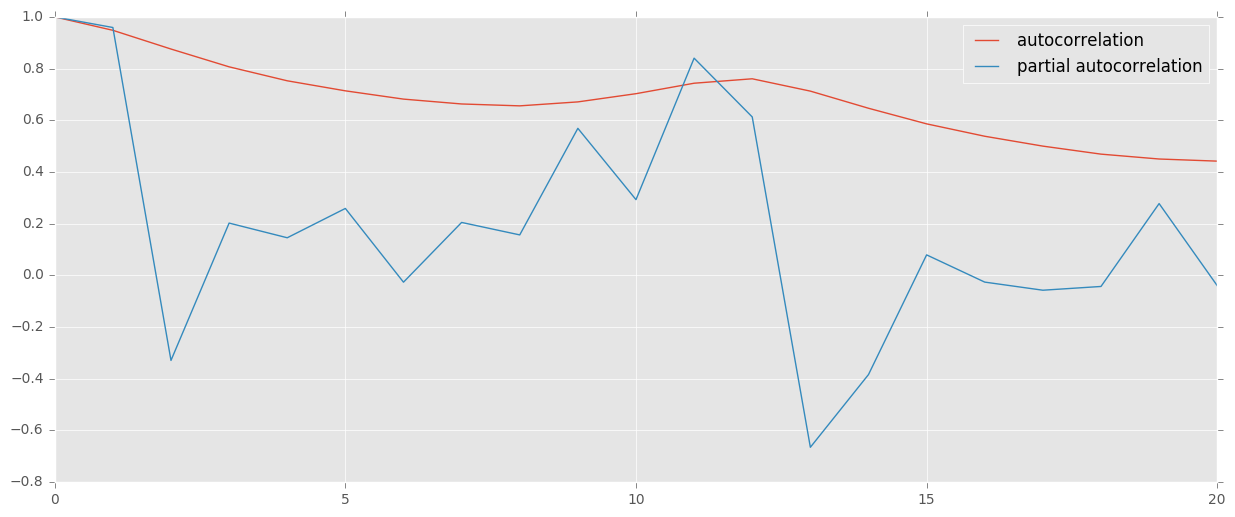

In [245]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(apts, nlags=20)
lag_pacf = pacf(apts, nlags=20, method='ols')
plt.plot(lag_acf, label='autocorrelation')
plt.plot(lag_pacf, label='partial autocorrelation')
plt.legend(loc='best')

Autocorrelation and Partial autocorrelation are commonly used to obtain P and Q values as parameters to fit an ARIMA model. <br>
See also https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Time_Series_Analysis/Time_Series_AirPassenger.ipynb

## Forecasting time series

There are many ways of forecasting time series. In this analysis we have used the following python modules: PyFlux

### ARIMA

ARIMA models are the classic Box-Jenkins tool for time-series forecasting. They take the form $ARIMA(p,d,q)$ where $p$ is the number of autoregressive lags, $d$ is the degree of differencing and $q$ is the number of moving average lags. See [Here](http://www.pyflux.com/arima-models/) and [Here](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average).

ARIMA is an extension of ARMA models in order to deal with non-stationarity. The I (for Integrated) means that the algorithm applies differencing steps to make the series stationary in order to fit the model. PyFlux only supports the non-seasonal variant of ARIMA ($ARIMA(p,d,q)$).

The forecast intervals (confidence intervals for forecasts) for ARIMA models are based on assumptions that the residuals are uncorrelated and normally distributed. If either of these assumptions does not hold, then the forecast intervals may be incorrect. For this reason, researchers plot the ACF and histogram of the residuals to check the assumptions before producing forecast intervals.

In [9]:
type(apts)

pandas.core.series.Series

In [17]:
arimaModel = pyflux.ARIMA(ps.DataFrame(apts), ar=4, ma=4, integ=0)
# using the maximum likelyhood point mass estimate to estimate latent variables
x = arimaModel.fit("MLE")
x.summary()

ARIMA(4,0,4)                                                                                              
======================================================= ==================================================
Dependent Variable: 0                                   Method: MLE                                       
Start Date: 1949-05-01 00:00:00                         Log Likelihood: -654.4933                         
End Date: 1960-12-01 00:00:00                           AIC: 1328.9866                                    
Number of observations: 140                             BIC: 1358.4031                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 1.2564     0.7271     1.728    0.084    (-0.1687 | 2.6815)       
AR(1)                                

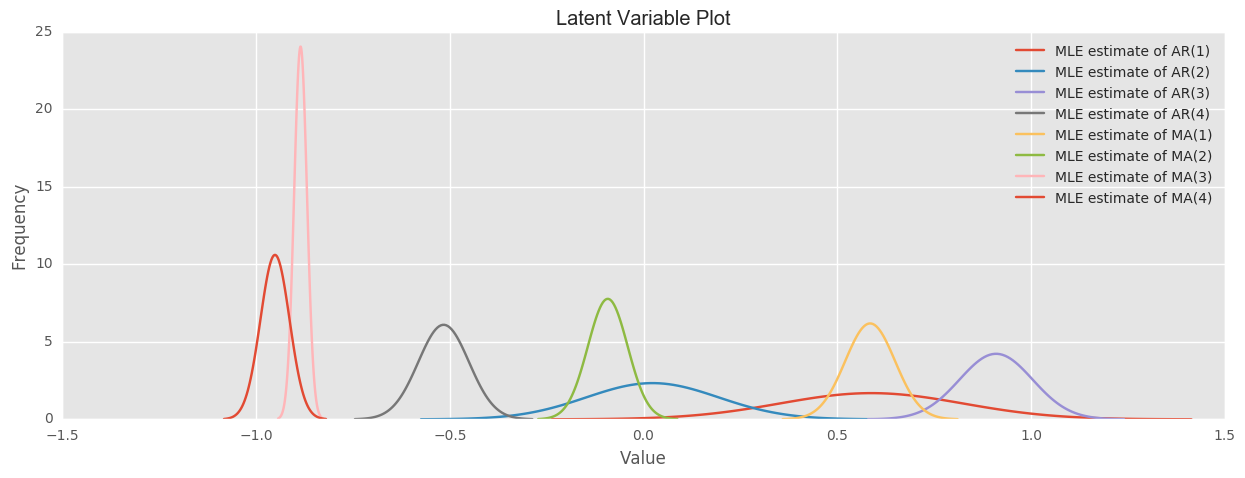

In [18]:
arimaModel.plot_z(indices=range(1,9))

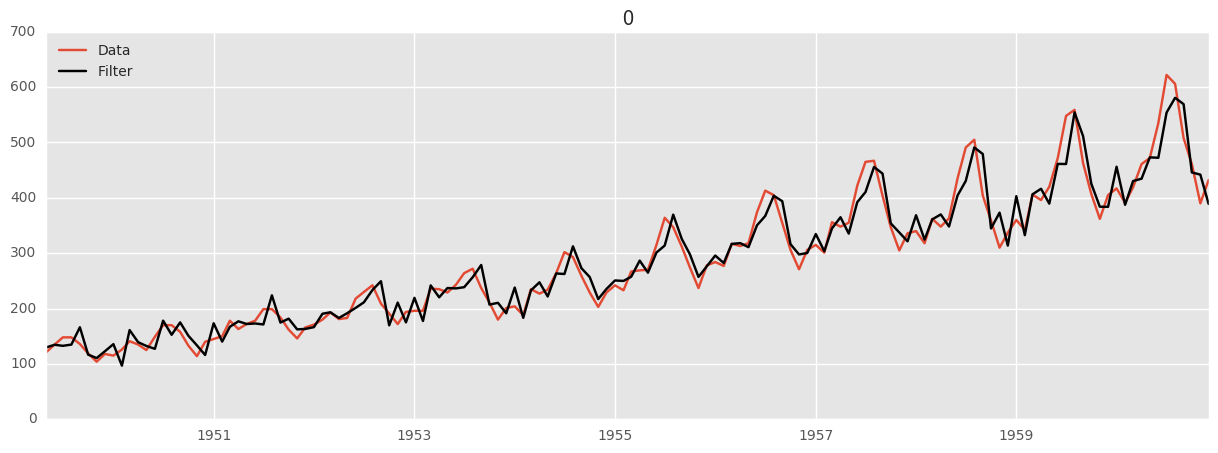

In [19]:
arimaModel.plot_fit(figsize=(15,5))

We can plot an in-sample prediction to look at the performance of the model in forecasting.

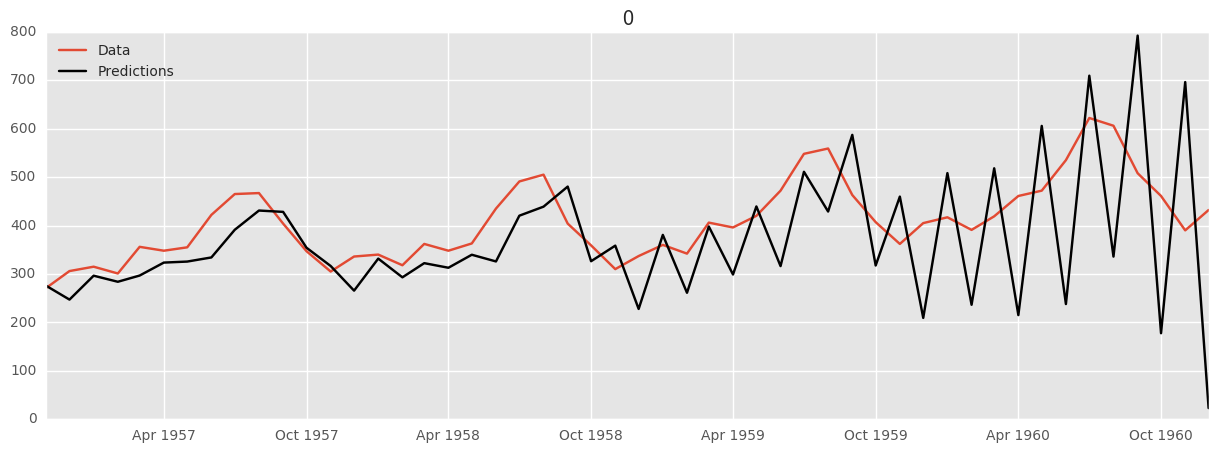

In [20]:
arimaModel.plot_predict_is(50,figsize=(15,5))

We can now predict future airline passanger numbers

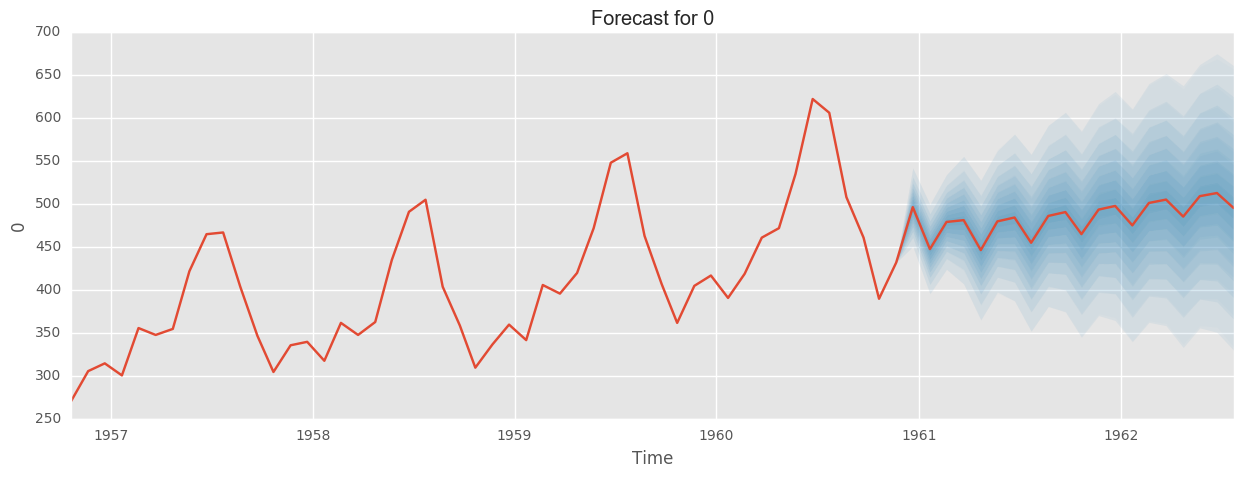

In [22]:
arimaModel.plot_predict(h=20,past_values=50,figsize=(15,5))

As you can see the model prediction is not very plausible. Note that we used a model without an the I component, so basically an ARMA model. Since our passenger data is non-stationary we really should be differencing the data to obtain better results.

In [48]:
arimaModel_2 = pyflux.ARIMA(ps.DataFrame(apts), ar=4, ma=4, integ=3 )
x2 = arimaModel.fit("M-H")
x2.summary()

Acceptance rate of Metropolis-Hastings is 0.037
Acceptance rate of Metropolis-Hastings is 0.3036

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2032
Acceptance rate of Metropolis-Hastings is 0.4012
Acceptance rate of Metropolis-Hastings is 0.2908
ARIMA(4,0,4)                                                                                              
======================================================= ==================================================
Dependent Variable: 0                                   Method: Metropolis Hastings                       
Start Date: 1949-05-01 00:00:00                         Unnormalized Log Posterior: -734.0406             
End Date: 1960-12-01 00:00:00                           AIC: 1488.08124444                                
Number of observations: 140                             BIC: 1517.49766866                                
Latent Variable                          Median             Mean               95%

Comparing the  Akaike information criterion (AIC) and the Bayesian information criterion (BIC) we see no difference with our previous model. For these criteria we are looking for lower values. Lower is better.

note: Unfortunately PyFlux 0.4.0 can't deal with a [non-zero integ parameter](https://github.com/RJT1990/pyflux/issues/60) so we'll have to look at another ARIMA implementation to test this.

#### Dynamic autoregressive models

Dynamic autoregressive models are an extension of the ARIMA model where the autoregression coefficients can vary over time.

In [58]:
arima_dam = pyflux.DAR(ps.DataFrame(apts), ar=4, integ=0)
x_dam = arima_dam.fit("MLE")
x.summary()

ARIMA(4,0,4)                                                                                              
======================================================= ==================================================
Dependent Variable: 0                                   Method: MLE                                       
Start Date: 1949-05-01 00:00:00                         Log Likelihood: -654.4933                         
End Date: 1960-12-01 00:00:00                           AIC: 1328.9866                                    
Number of observations: 140                             BIC: 1358.4031                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 1.2564     0.7271     44.3776  0.0      (30.8418 | 33.692)       
AR(1)                                

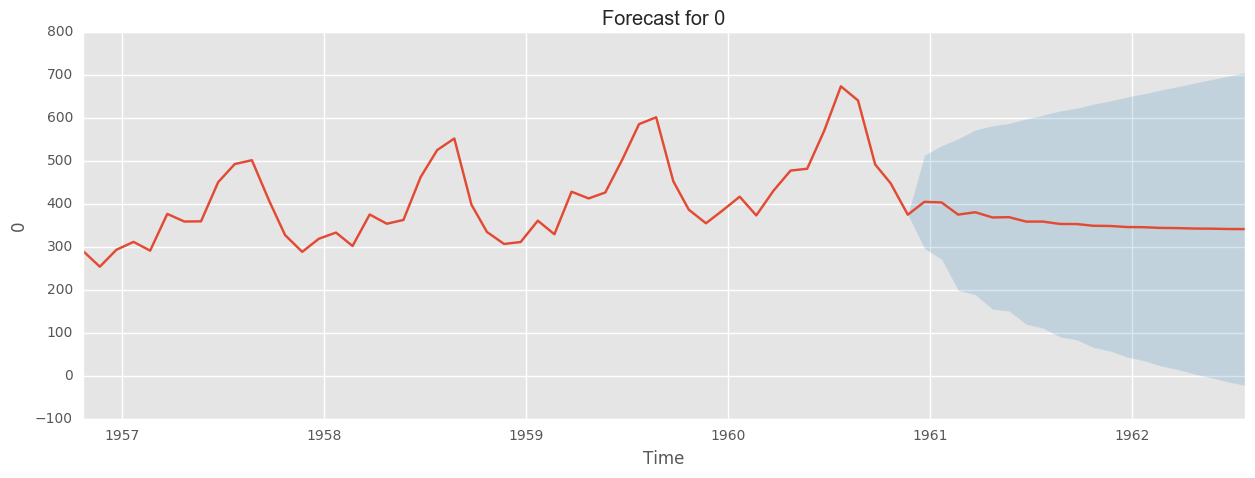

In [59]:
arima_dam.plot_predict(h=20,past_values=50,figsize=(15,5))

Again: PyFlux does not deal well with the integ parameter. When tried this does yield a prediction but we only get a differenced output without a way to un-difference the predictions.

### GARCH

generalized autoregressive conditional heteroscedasticity ([GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity#GARCH)). GARCH is an observation driven model, modeling condtionaly volatility. GARCH takes the form $GARCH(p,q)$ where $p$ is the order of the GARCH terms and 
$q$ is the order of the ARCH terms.

GARCH is often applied to financial time series.  however: including the fact that most asset returns display heavy tails, and even with an assumption of t-distributed errors, the ARCH terms will likely overreact to tail events.

In [80]:
garch_model = pyflux.GARCH(ps.DataFrame(apts),p=0,q=4)
x_garch = garch_model.fit()
x_garch.summary()

Hessian not invertible! Consider a different model specification.

GARCH(0,4)                                                                                                
======================================================= ==================================================
Dependent Variable: 0                                   Method: MLE                                       
Start Date: 1949-05-01 00:00:00                         Log Likelihood: -822.2502                         
End Date: 1960-12-01 00:00:00                           AIC: 1656.50049704                                
Number of observations: 140                             BIC: 1674.15035157                                
Latent Variable                          Estimate  
======================================== ==========
Vol Constant                             0.0009    
q(1)                                     1.0       
q(2)                                     0.0       
q(3)                           

Again the AIC and BIC are higher than our initial ARMA model. So at first glance this model should perform worse.

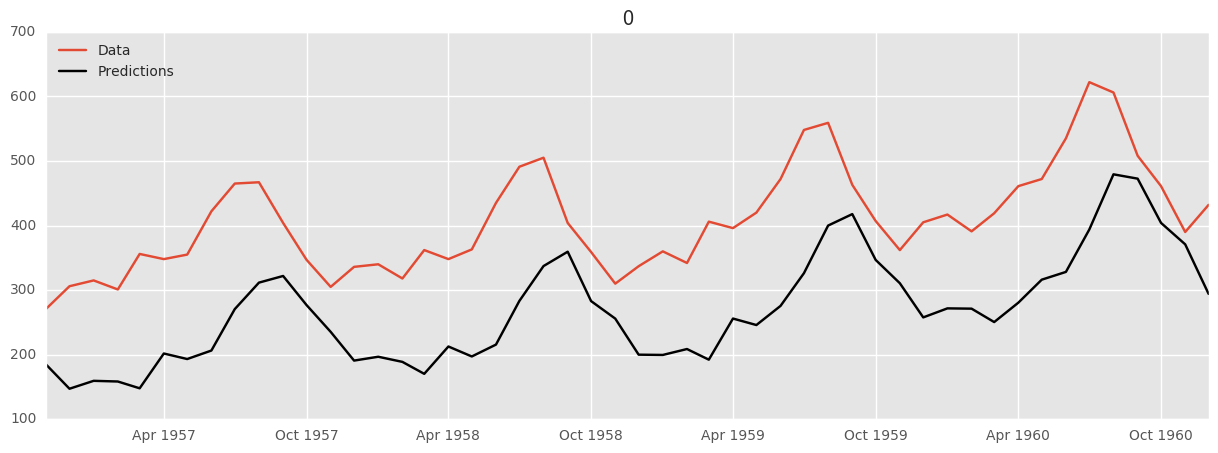

In [81]:
garch_model.plot_predict_is(h=50,figsize=(15,5))

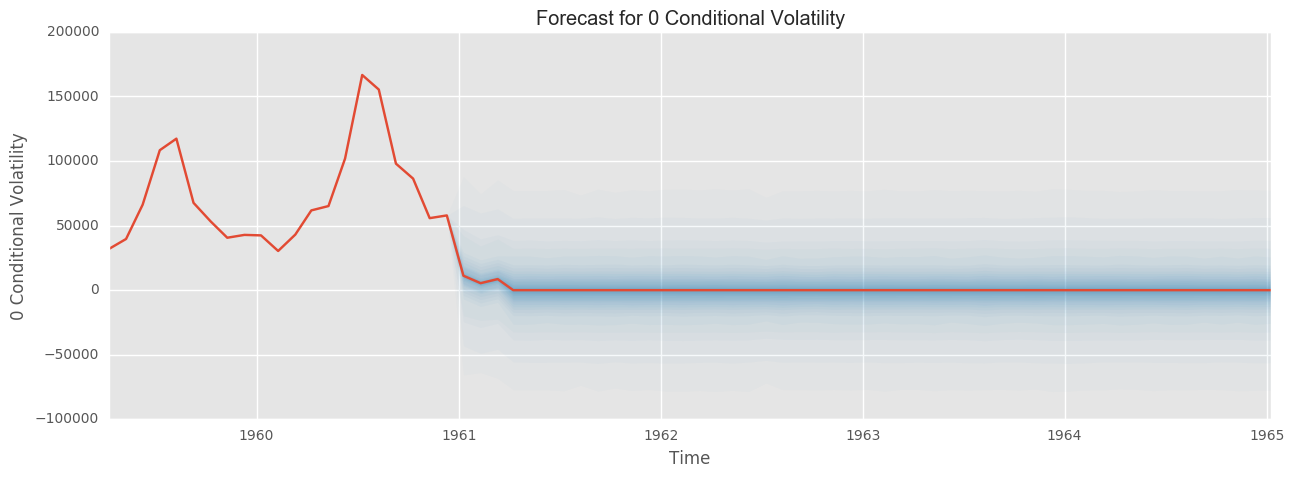

In [82]:
garch_model.plot_predict(past_values=20, h=50, figsize=(15,5))

The predictive power of our GARCH model as plotted above seems very dubious indeed.

### GAS

Generalized Autoregressive Score (GAS) models are a recent class of observation-driven time-series model for non-normal data. A gas model takes the form $GAS(p,s,f)$ where $p$ is the number autoregressive lags, $s$ is a scaling factor and $f$ is the family of the distribution of the data.

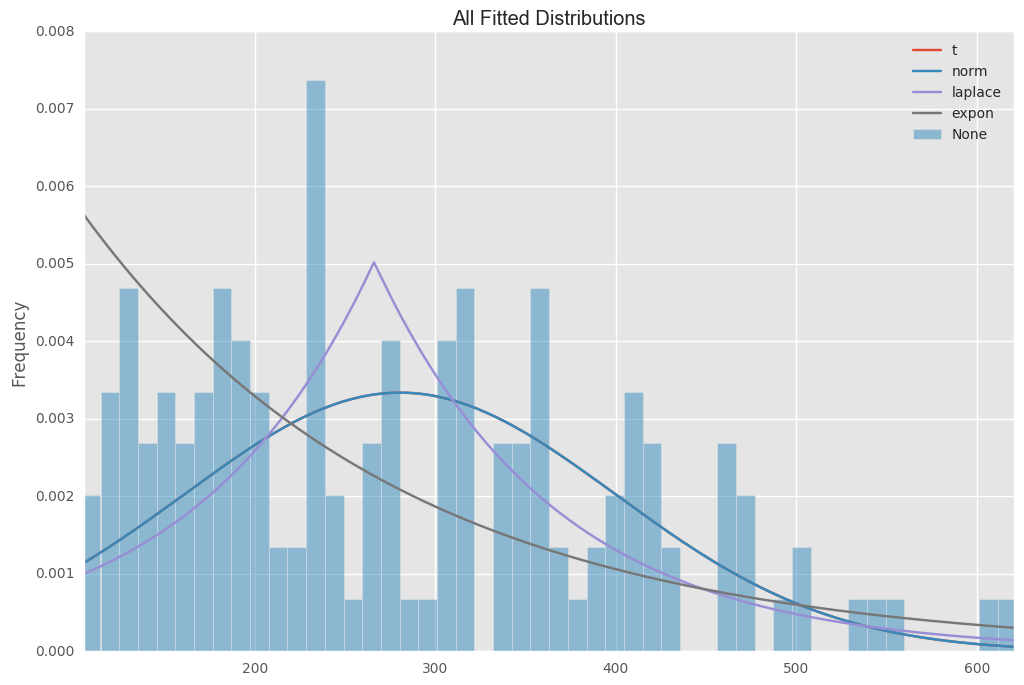

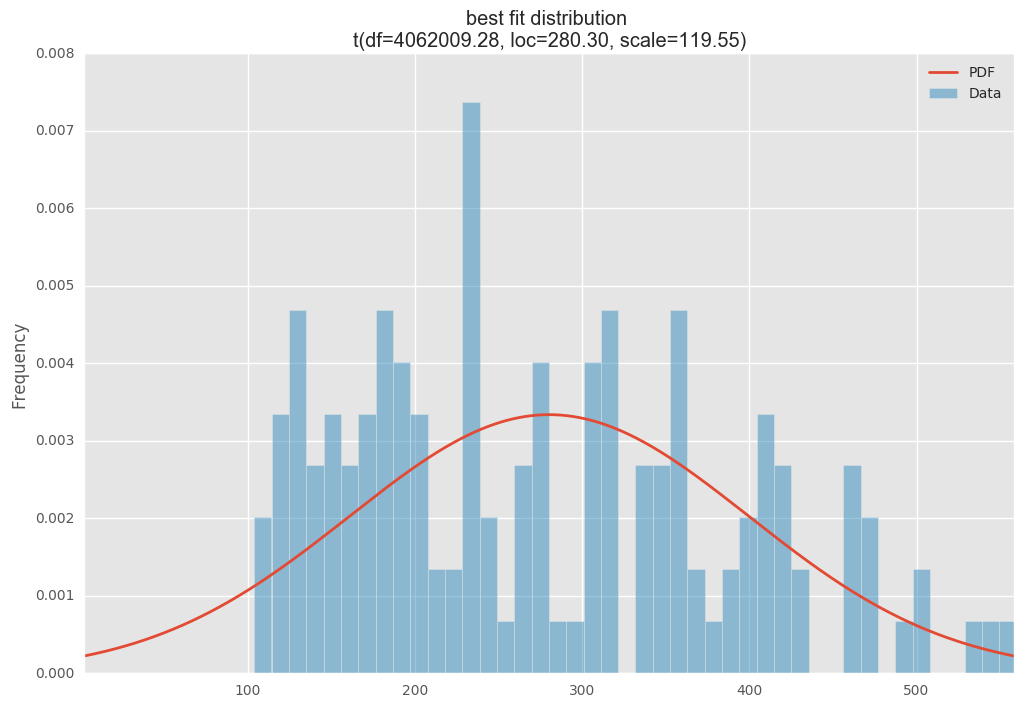

In [107]:
#let's see what distribution our data follows:
import warnings
import scipy.stats as st
import statsmodels as sm

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
          st.t, st.skew, st.norm, st.laplace, st.expon, st.poisson 
#         st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
#         st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
#         st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
#         st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
#         st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
#         st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
#         st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
#         st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
#         st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
#         st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        ps.Series(pdf, x).plot(ax=ax, label=distribution.name)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = ps.Series(y, x)

    return pdf

# Load data from statsmodels datasets
#data = ps.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
data = apts

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'All Fitted Distributions')
ax.legend(loc='best')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'best fit distribution \n' + dist_str)
ax.legend(loc='best')

From the distributions that PyFlux supports, the Poisson distribution fit's best with our data.

In [109]:

gas_model = pyflux.GAS(ar=1,sc=1,data=ps.DataFrame(apts),family=pyflux.GASPoisson())
#gas_model = pyflux.GAS(ar=1,sc=1,data=ps.DataFrame(apts),family=pyflux.GASt())

gas_x = gas_model.fit()
gas_x.summary()

Poisson GAS(1,0,1)                                                                                        
======================================================= ==================================================
Dependent Variable: 0                                   Method: MLE                                       
Start Date: 1949-02-01 00:00:00                         Log Likelihood: -745.2351                         
End Date: 1960-12-01 00:00:00                           AIC: 1496.4703                                    
Number of observations: 143                             BIC: 1505.3588                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0566     nan        nan      nan      (nan | nan)              
AR(1)                                

Again we have a higher AIC and BIC

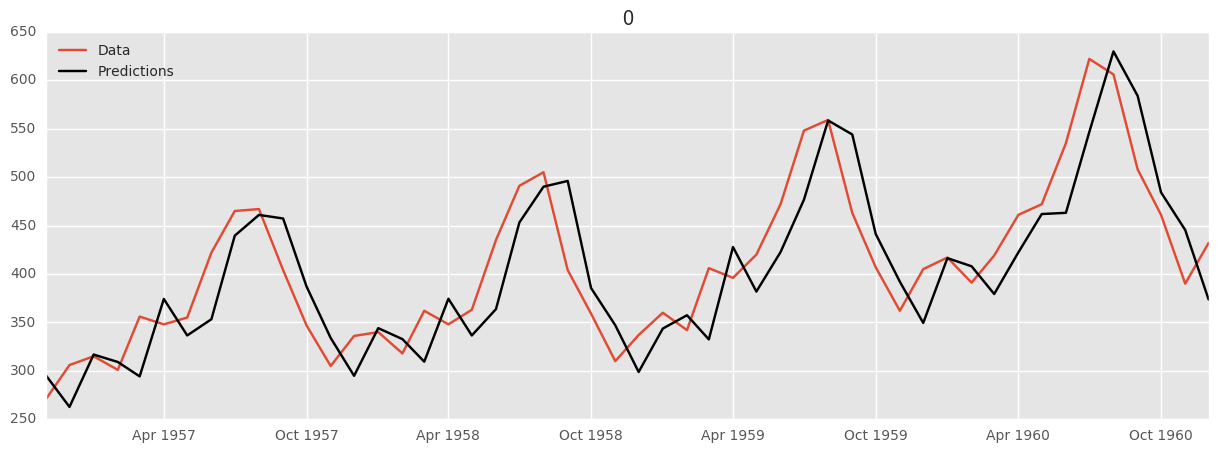

In [110]:
gas_model.plot_predict_is(h=50, figsize=(15,5))

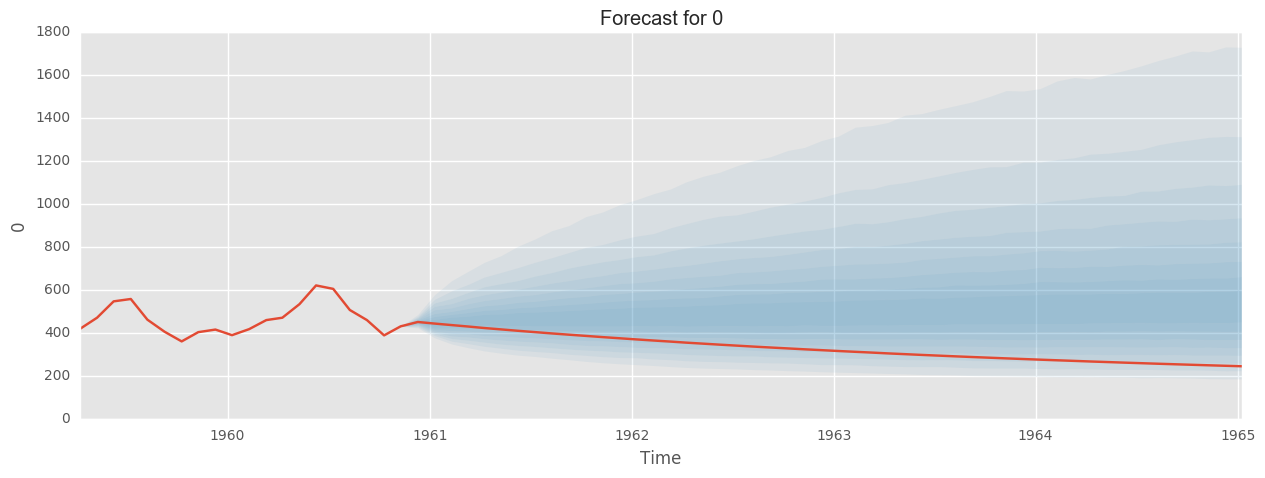

In [111]:
gas_model.plot_predict(past_values=20, h=50, figsize=(15,5))

### GP-NARX

A Gaussian Process Nonlinear Autoregressive model (GP-NARX) generalizes the linear autoregressive model. As such, I don't expect significantly different results from previous autoregressive model techniques.

### Gaussian state space

Gaussian state space models – often called structural time series or unobserved component models – provide a way to decompose a time series into several distinct components. These models are not very well suited to generate forecasts.

### Bayesian VAR modeling

Vector autoregression (VAR) is used to model linear relationships between multiple variables. Vector autoregressions (VARs) are one of the most popular econometric models, and they find wide usage both for forecasting and structural analysis in academia and in central banks. However, they are not without problems. Many applications of these models are heavily parameterized and overfit the historical data, leading to poor generalisability out-of-sample. There are a number of responses to this problem: 

* The frequentist response to this problem is that the model is ‘over-parameterized’ and that the number of parameters should be chosen according to an information criterion or cross-validation.
* The modern frequentist response is that the problem is not the number of parameters, per say, but more the fact that we are not applying sufficient regularization to the parameters, especially longer lags.
* The Bayesian response puts the regularization argument in a coherent theoretical framework through the introduction of informative priors.

## Pandas time series functionality

Pandas has extensive support for time based indexing. Below is an example of a times series (as ps.Series, with a time index). Slicing and intelligent indexing (including business hours/days/years). Time calculations are easy using various offset classes that can simply be added to a time.

In [201]:
import datetime
from pandas.tseries.offsets import *

d = datetime.datetime.now()
o = DateOffset(days=5, hours=2)
print(d)
print(d+o)

2016-10-26 23:03:45.639249
2016-11-01 01:03:45.639249


Pandas allows you to easily shift or lag a timeseries to align a series.

In [202]:
ts = ps.date_range(datetime.datetime.now(), periods=24, freq='s')
ts[1:10]

DatetimeIndex(['2016-10-26 23:03:47.428706', '2016-10-26 23:03:48.428706',
               '2016-10-26 23:03:49.428706', '2016-10-26 23:03:50.428706',
               '2016-10-26 23:03:51.428706', '2016-10-26 23:03:52.428706',
               '2016-10-26 23:03:53.428706', '2016-10-26 23:03:54.428706',
               '2016-10-26 23:03:55.428706'],
              dtype='datetime64[ns]', freq='S')

In [203]:
ts[1:10].shift(5)

DatetimeIndex(['2016-10-26 23:03:52.428706', '2016-10-26 23:03:53.428706',
               '2016-10-26 23:03:54.428706', '2016-10-26 23:03:55.428706',
               '2016-10-26 23:03:56.428706', '2016-10-26 23:03:57.428706',
               '2016-10-26 23:03:58.428706', '2016-10-26 23:03:59.428706',
               '2016-10-26 23:04:00.428706'],
              dtype='datetime64[ns]', freq='S')

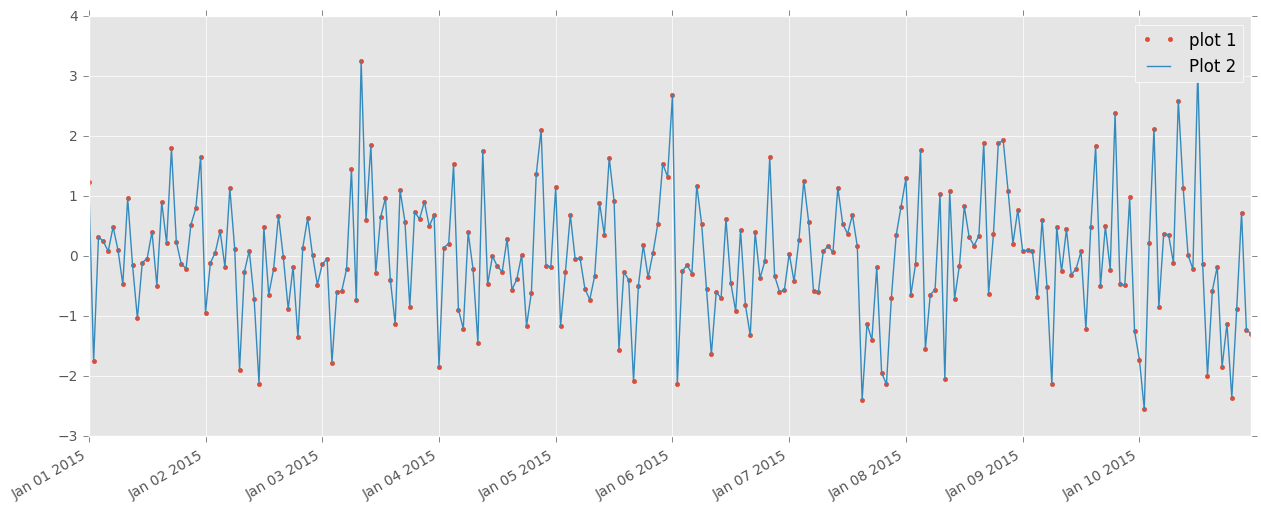

In [204]:
import matplotlib.pylab as plt

#Generate data
rng = ps.date_range('1/1/2015', periods=240, freq='H')
ts = ps.Series(np.random.randn(len(rng)), index=rng)

#to generated a range of business days you can use ps.bdate_range()

#plot values (both xy and lineplot)
plt.plot(ts, '.', label='plot 1')
ax = ts.plot(label='Plot 2')
ax.legend()

In [205]:
#Change the frequency of a time series
# to 45 minute frequency and forward fill
converted = ts.asfreq('15Min', 'pad') 
converted[1:10]

2015-01-01 00:15:00    1.235314
2015-01-01 00:30:00    1.235314
2015-01-01 00:45:00    1.235314
2015-01-01 01:00:00   -1.748096
2015-01-01 01:15:00   -1.748096
2015-01-01 01:30:00   -1.748096
2015-01-01 01:45:00   -1.748096
2015-01-01 02:00:00    0.324323
2015-01-01 02:15:00    0.324323
Freq: 15T, dtype: float64

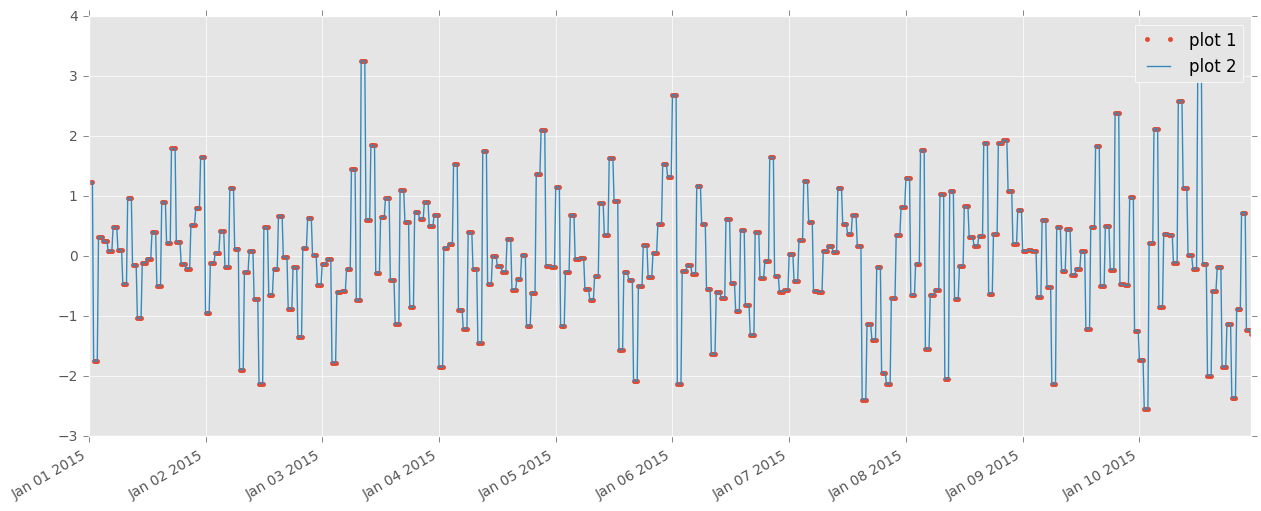

In [206]:
plt.plot(converted, '.', label='plot 1')
ax = converted.plot(label='plot 2')
ax.legend()

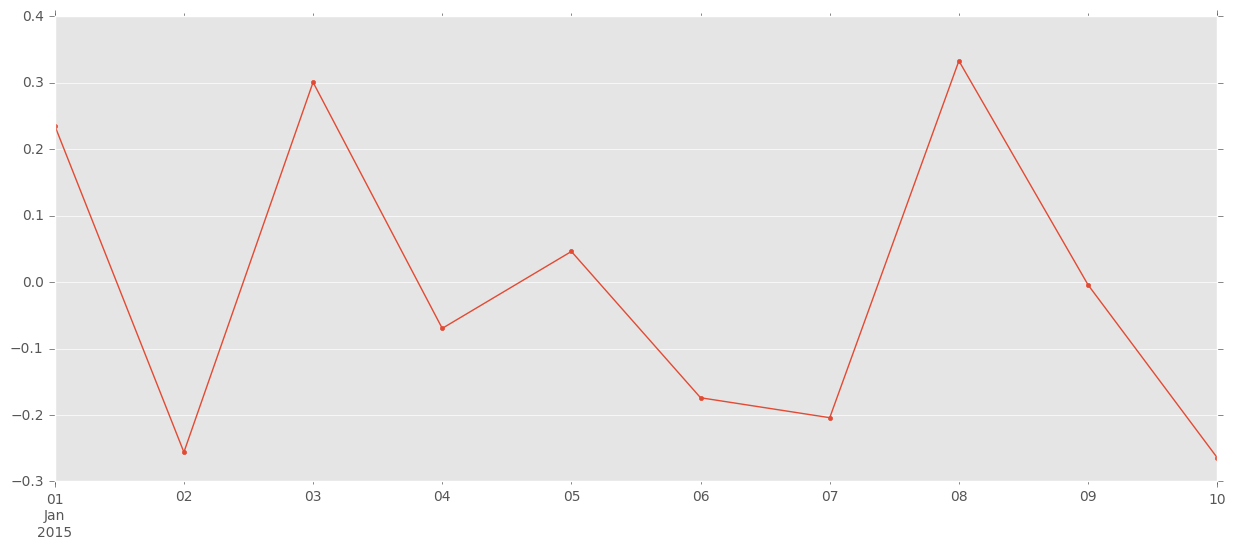

In [207]:
#resampling
# Daily means
daily = ts.resample('D').mean()
daily.plot(marker='.')

## Comparison of ARIMA vs RNN based forecasting

First we will use Keras to create a [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) (long-short term memory) RNN (recurrent neural network) to predict our passenger data. Keras implements the LSTM layer as described in [Hochreiter & Schimdthuber (1997)](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf).

In [6]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
np.random.seed(7)

# cast passenger data as float, RNN requires floating point values for training
dataset = apts.astype('float32')

#normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = dataset.values.reshape(-1,1)
dataset = scaler.fit_transform(dataset)
# split into train and test sets

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

#let's create a dataset wit two features: passengers(t), passengers(t+1)
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

(96, 48)


The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [7]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=1)

Epoch 1/100
94/94 [==============================] - 0s - loss: 0.0461     
Epoch 2/100
94/94 [==============================] - 0s - loss: 0.0227     
Epoch 3/100
94/94 [==============================] - 0s - loss: 0.0160     
Epoch 4/100
94/94 [==============================] - 0s - loss: 0.0143     
Epoch 5/100
94/94 [==============================] - 0s - loss: 0.0134     
Epoch 6/100
94/94 [==============================] - 0s - loss: 0.0126     
Epoch 7/100
94/94 [==============================] - 0s - loss: 0.0116     
Epoch 8/100
94/94 [==============================] - 0s - loss: 0.0106     
Epoch 9/100
94/94 [==============================] - 0s - loss: 0.0095     
Epoch 10/100
94/94 [==============================] - 0s - loss: 0.0083     
Epoch 11/100
94/94 [==============================] - 0s - loss: 0.0071     
Epoch 12/100
94/94 [==============================] - 0s - loss: 0.0059     
Epoch 13/100
94/94 [==============================] - 0s - loss: 0.0048     
Epoch 14

In [8]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.14 RMSE
Test Score: 50.03 RMSE


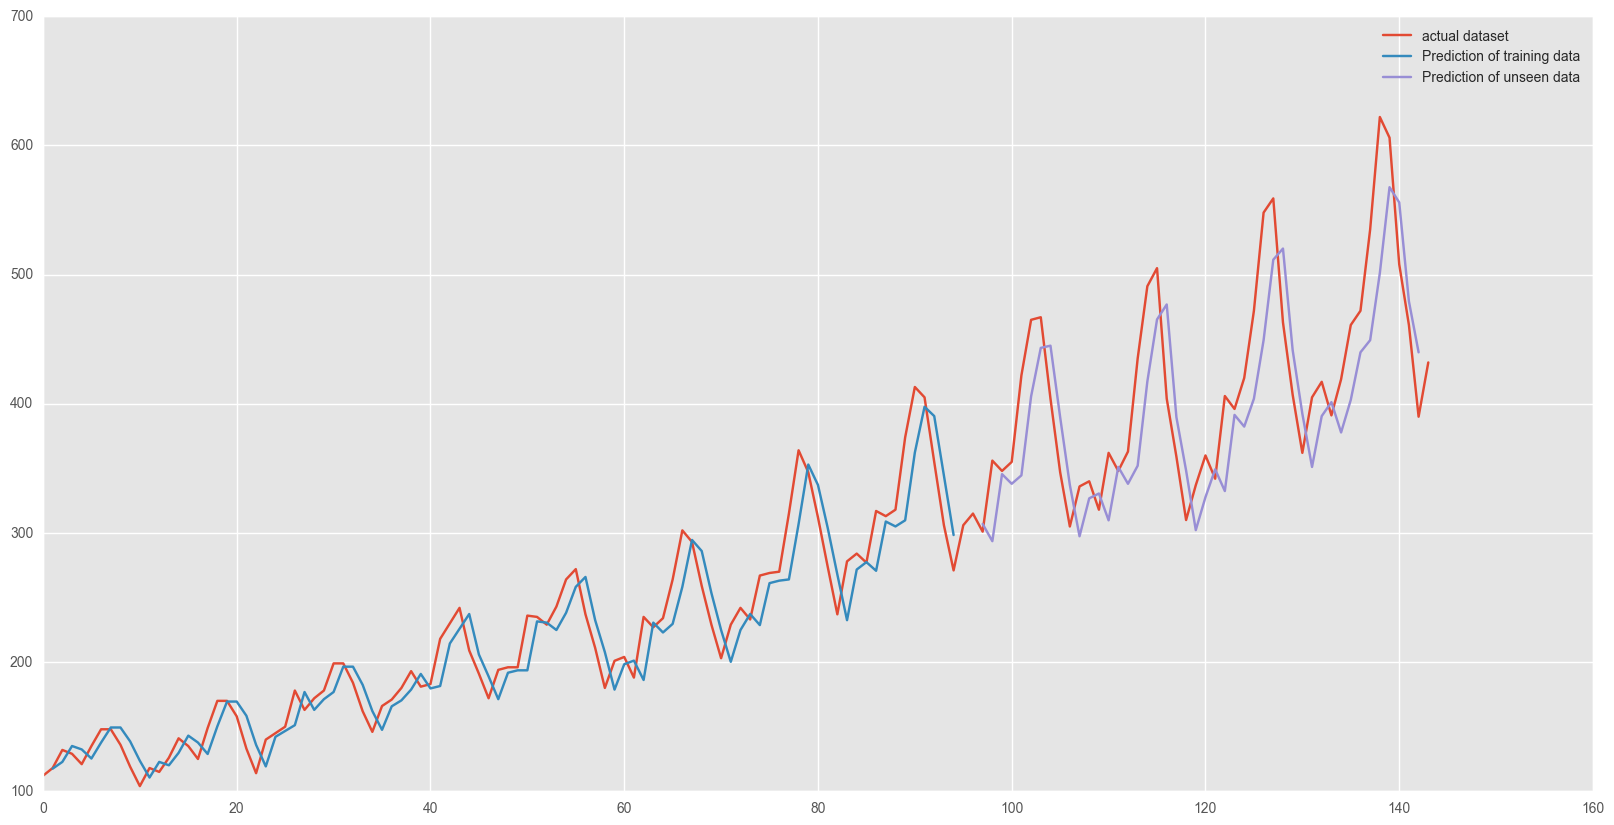

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,10])
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label="actual dataset")
plt.plot(trainPredictPlot, label="Prediction of training data")
plt.plot(testPredictPlot, label="Prediction of unseen data")
plt.legend()
plt.show()

Our RNN only makes a single value prediction. As the plot shows the short-term prediction follows the data nicely. But how well can an RNN generalize futher out in time? How much structure did it actually absorb?

Comparing this RNN with ARIMA we see that the RNN creates a better fit with the training data. The ARIMA models showed a more noisy fit. TODO: calculate RMSE for ARIMA or AIC or BIC for the RNN model to compare by those measures. 

### LSTM RNN with more memory

Epoch 1/500
0s - loss: 0.0094
Epoch 2/500
0s - loss: 0.0033
Epoch 3/500
0s - loss: 0.0028
Epoch 4/500
0s - loss: 0.0018
Epoch 5/500
0s - loss: 0.0014
Epoch 6/500
0s - loss: 0.0011
Epoch 7/500
0s - loss: 0.0011
Epoch 8/500
0s - loss: 0.0012
Epoch 9/500
0s - loss: 0.0012
Epoch 10/500
0s - loss: 7.1662e-04
Epoch 11/500
0s - loss: 0.0011
Epoch 12/500
0s - loss: 8.1033e-04
Epoch 13/500
0s - loss: 8.5281e-04
Epoch 14/500
0s - loss: 8.2740e-04
Epoch 15/500
0s - loss: 6.7065e-04
Epoch 16/500
0s - loss: 7.2890e-04
Epoch 17/500
0s - loss: 7.1957e-04
Epoch 18/500
0s - loss: 6.0178e-04
Epoch 19/500
0s - loss: 5.7075e-04
Epoch 20/500
0s - loss: 5.4289e-04
Epoch 21/500
0s - loss: 5.2608e-04
Epoch 22/500
0s - loss: 5.0785e-04
Epoch 23/500
0s - loss: 5.5758e-04
Epoch 24/500
0s - loss: 5.9211e-04
Epoch 25/500
0s - loss: 6.2630e-04
Epoch 26/500
0s - loss: 7.3325e-04
Epoch 27/500
0s - loss: 4.8055e-04
Epoch 28/500
0s - loss: 6.7623e-04
Epoch 29/500
0s - loss: 6.3781e-04
Epoch 30/500
0s - loss: 5.1178e-04

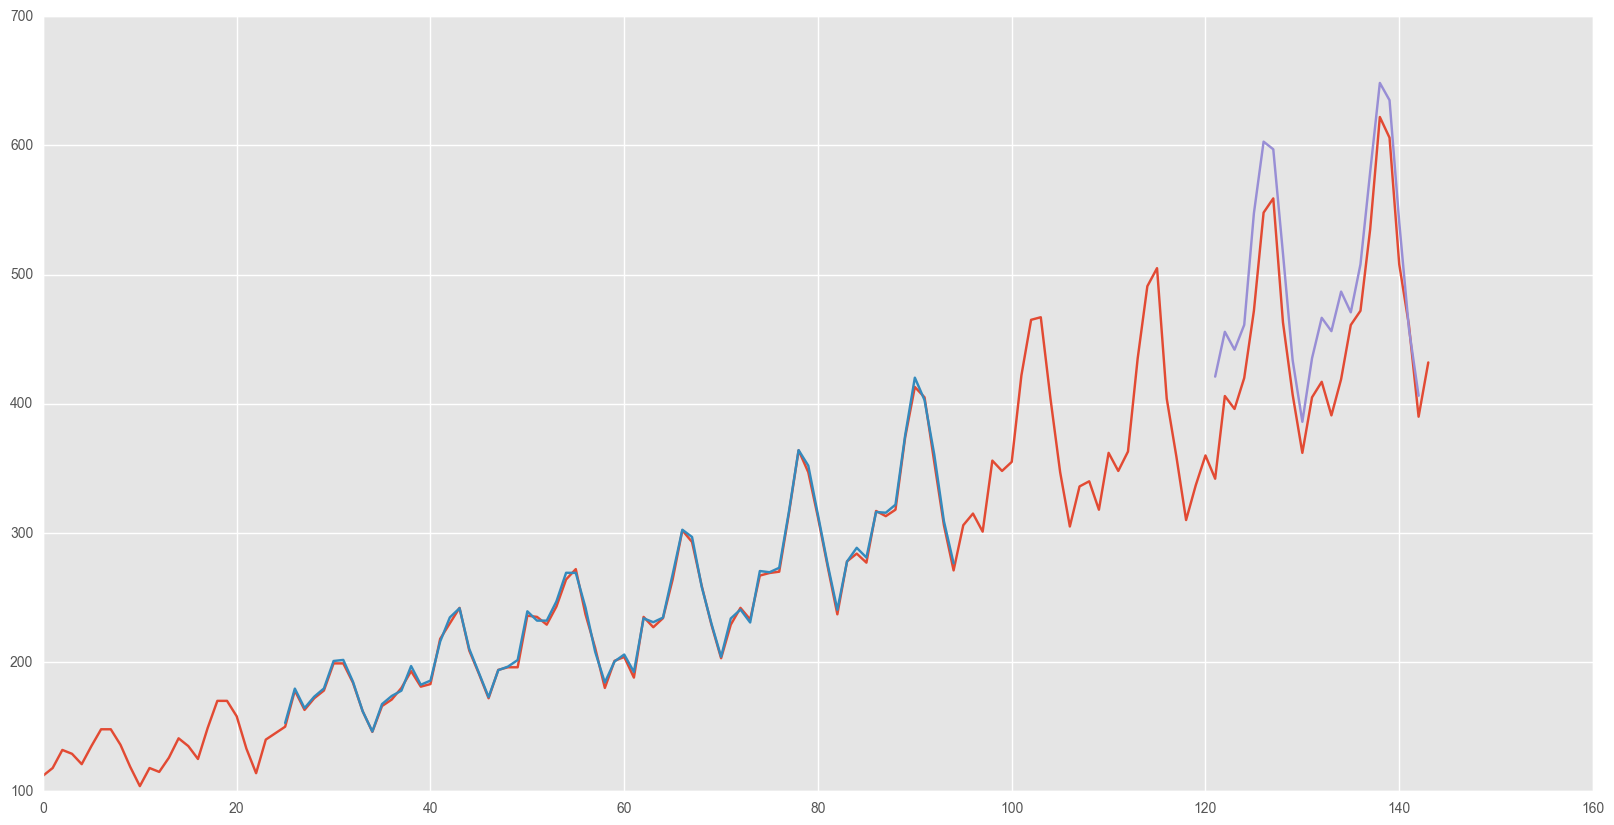

/Users/willem/dev/ml/keras/mlpy/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


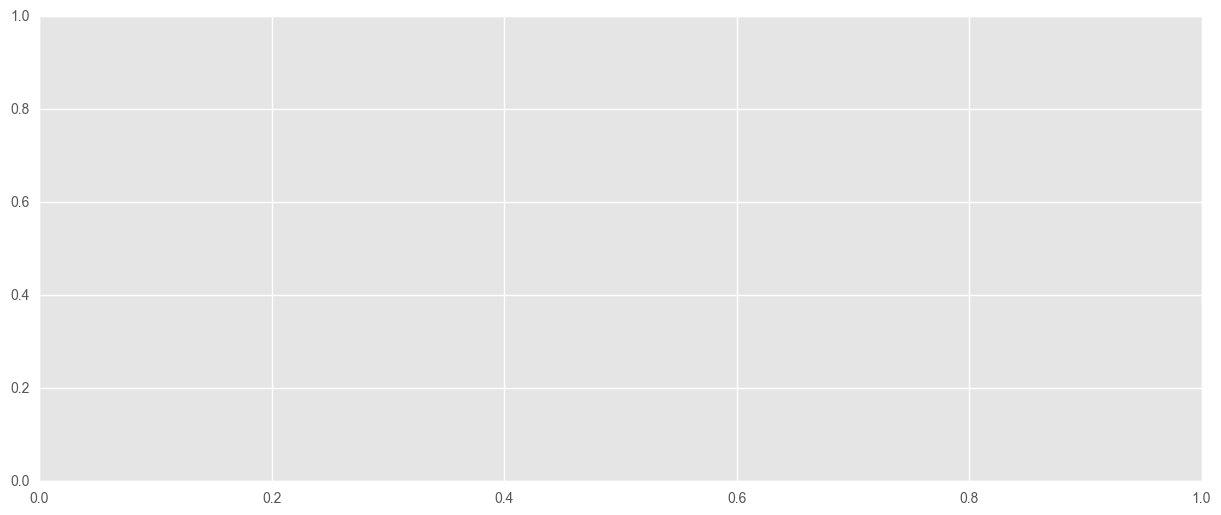

In [12]:
look_back = 25
n_epoch = 500
LSTM_blocks = 200

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(LSTM_blocks, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=n_epoch, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


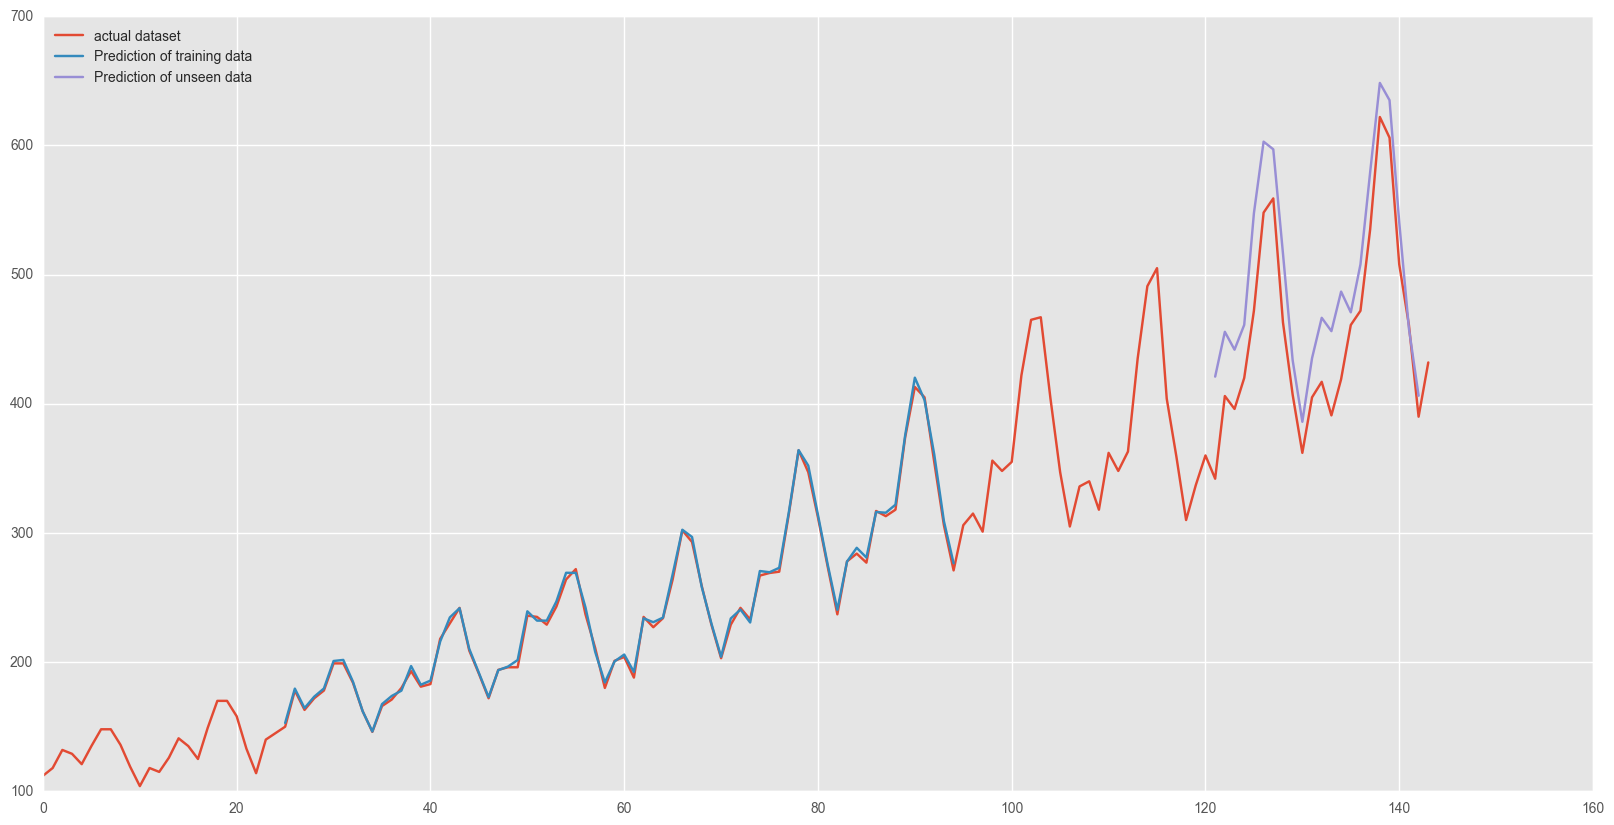

In [14]:
# plot baseline and predictions
plt.figure(figsize=[20,10])
plt.plot(scaler.inverse_transform(dataset), label="actual dataset")
plt.plot(trainPredictPlot, label="Prediction of training data")
plt.plot(testPredictPlot, label="Prediction of unseen data")
plt.legend(loc='best')
plt.show()


### LSTM for longer output period

### GRU RNN model

http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/

# TODO

Topics:
* reservoir computing using Oger: http://organic.elis.ugent.be/oger
* Alternative ARIMA libs: http://conference.scipy.org/scipy2011/slides/mckinney_time_series.pdf
* PyBrain as alternative for Keras
* leveraging CUDA in TS analysis -> especially with RNN based modeling
* Exploring relationships between time series, specifically time-relationships e.g. behavior of A signals future behavior of B!
* more generally, forecasting only from a single series seems foolhardy. Usually you are looking at the expression of behavior of a complex system. For which it is likely you have more information to put into your model. So how can you effectively model everything you know about that system. You have a time series but you may also have static variables, timestamped data, correlating variables, etc. etc. I don't see much work being done on more complex models like this.
* Bayesian inference on event influence on time series
* Feature extraction from time series (for anomaly detection)
* Classification of timeseries (pattern recognition), this implies you can determine time-slices to classify
* [Wavelets](https://www.researchgate.net/profile/Jean_Sanderson/publication/227464409_Measuring_dependence_between_non-stationary_time_series_using_the_locally_stationary_wavelet_model/links/5463780a0cf2c0c6aec4bffe.pdf?origin=publication_detail)
* [more wavelets](http://biostochastics.slu.se/publikationer/dokument/Report2007_2.pdf)
* [still more wavelets](http://stats.lse.ac.uk/fryzlewicz/flsw/pred_lsw.pdf)
* [Heteroscedasticity](https://www.researchgate.net/profile/Jean_Sanderson/publication/227464409_Measuring_dependence_between_non-stationary_time_series_using_the_locally_stationary_wavelet_model/links/5463780a0cf2c0c6aec4bffe.pdf?origin=publication_detail)
* [Multivariate adaptive regression splines](https://www.wikiwand.com/en/Multivariate_adaptive_regression_splines)
* [Autoregressive conditional heteroskedasticity](https://www.wikiwand.com/en/Autoregressive_conditional_heteroskedasticity)
* [hybrid ARIMA-GARCH](http://ijbds.usb.ac.ir/pdf_2198_4150a14b626373be361539db9796e1de.html)
* [Vitaly Kuznetzov](http://cims.nyu.edu/~vitaly/)
* [Learning theory and algorithms for forecasting non-stationary time series.](http://www.cs.nyu.edu/~mohri/pub/ts.pdf)
* [Time series prediction and online learning.](http://www.cs.nyu.edu/~mohri/pub/otbts.pdf)
* RNN topologies
* RBM for time series
* Graphical models
* Deep Temporal Sigmoid Belief Networks
* [Minimax model for time series prediction](https://papers.nips.cc/paper/5730-minimax-time-series-prediction.pdf)
* [Learning Stationary Time Series using Gaussian Processes with Nonparametric Kernels](https://papers.nips.cc/paper/5772-learning-stationary-time-series-using-gaussian-processes-with-nonparametric-kernels.pdf)
* [multivariate time series](https://drive.google.com/file/d/0Bx7depbNYaFIa0NDZkVrcTRCMVlwamlXelFocURSdWNoWGZZ/view)
* [Autoregressive Kernels](http://arxiv.org/abs/1101.0673)
* [Consistent Algorithms for Clustering Time Series](http://www.jmlr.org/papers/volume17/khaleghi16a/khaleghi16a.pdf)
* [Temporal Regularized Matrix Factorization for High-dimensional Time Series Prediction](http://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf)
* [Granger Causality Analysis in Irregular Time Series](http://www-bcf.usc.edu/~liu32/paper/sdm2012_irr.pdf)
* [Toward Learning and Mining from Uncertain Time-Series Data for Activity Prediction](http://eecs.wsu.edu/~bminor/KDD_MiLeTS.pdf)
* [Probabilistic time series forecasting with boosted additive models: an application to smart meter data](http://www.souhaib-bentaieb.com/papers/sigkdd-milets-probabilistic-forecasting.pdf)
* [Extracting Predictive Information from Heterogeneous Data Streams using Gaussian Processes.](http://arxiv.org/abs/1603.06202)
* [forecasting housing prices](https://github.com/rsvp/fecon235/blob/master/nb/fred-housing.ipynb#dt_2016-02-10_133519)
* [forecasting futures and FED rate](https://github.com/rsvp/fecon235/blob/master/nb/qdl-libor-fed-funds.ipynb#dt_2015-11-02_200321)
* [Derivatives analysis](https://github.com/rsvp/fecon235/blob/master/nb/qdl-COTR-positions.ipynb#dt_2015-11-25_103609)
* [bonds, equity and gold forecasting using geometric mean](https://github.com/rsvp/fecon235/blob/master/nb/fred-georeturns.ipynb#dt_2015-12-16_163517)
* [fecon library](https://github.com/rsvp/fecon235#dt_2015-08-01_094628)

Further inspiration:
https://cran.r-project.org/web/views/TimeSeries.html
http://biostochastics.slu.se/publikationer/dokument/Report2007_2.pdf